# Graded Assignment 2 - Air Quality and Weather in the Netherlands


# Introduction to This Template Notebook

* This is a **group** notebook.
* Make sure you work in a **copy** of `...-template.ipynb`,
**renamed** to `...-yourIDnrs.ipynb`,
where `yourIDnrs` is the TU/e identification numbers of the members of the group.

<div class="alert alert-danger" role="danger">
<h3>Integrity</h3>
<ul>
    <li>In this course you must act according to the rules of the TU/e code of scientific conduct.</li>
    <li>This exercise or graded assignment is to be executed by the members of the group independently from other people.</li>
    <li>You must not copy from the Internet, your friends, books... If you represent other people's work as your own, then that constitutes fraud and will be reported to the Examination Committee.</li>
    <li>Making your work available to others (complicity) also constitutes fraud.</li>
</ul>
</div>

You are expected to work with Python code and Markdown in this notebook.

Proceed in this notebook as follows:
* **Read** the assignment (separate PDF).
* **Write** your decisions/solutions/interpretations in the appropriate sections.
  * For this you can use both Code and Markdown cells. Information about how to use these cells is available in the _Getting Started_ assignment.
* **Run** _all_ code cells (also the ones _without_ your code),
    _in linear order_ from the first code cell.

**Personalize your notebook**:
1. Copy the following line of code:

  ```python
  AUTHOR_ID_NRS = ['1234567', '2234567', '3234567', '4234567']
  ```
1. Paste them between the marker lines in the next code cell.
1. Fill in the _identification numbers_ of all members of the group as a list of strings between the `Author` markers.
1. Run the code cell by putting the cursor there and typing **Control-Enter**.


In [1]:
#// BEGIN_TODO [Author] Name, Id.nr., Date, as strings (1 point)

AUTHOR_ID_NRS = ['1951432', '1704311', '1989200', '2021021']

#// END_TODO [Author]

## Table of Contents

- [Preparation](#Preparation)
    - [Load the libraries](#Load-the-libraries)
- [Part 1a. Hypothesis selection](#Part-1a:-Hypothesis-selection)
- [Part 1b. Hypothesis refinement](#Part-1b:-Hypothesis-refinement)
- [Part 2. Queries and data cleaning](#Part-2:-Queries-and-data-cleaning)
- [Part 3. Hypothesis testing and interpretation](#Part-3.-Hypothesis-testing-and-interpretation)
- [Part 4. Pitching results](#Part-4.-Pitching-results)

## Preparation
### Load the libraries

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression         # for linear regression
from sklearn.cluster import KMeans                        # for clustering
from sklearn.tree import DecisionTreeClassifier           # for decision tree mining
from sklearn.metrics import mean_absolute_error, confusion_matrix
from sklearn.model_selection import train_test_split
from treeviz import tree_print                            # to print decision tree

import scipy.stats as stats                               # to compute z-scores
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import sqlite3                                            # to interact with the database
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline                                 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns                                     # also improves the look of plots
sns.set()
plt.rcParams['figure.figsize'] = 10, 5                    # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1                 # to fix issue with seaborn box plots; needed after import seaborn

## Part 1a: Hypothesis selection

The below three Hypotheses had been developed during the first lab session and the first one was approved by our tutor:
1. **The seaside areas (coastal stations in noord-holland and zuid-holland) have windier weather condition compared to the inland areas. The assumption can be made from the collected data that specific stations indeed show results of less concentration of certain air comounds in the Netherlands based on wind factors since wind blows away the air compounds away which leads to a higher variability in their concentrations).**
2. A number of studies have found that the same compound reacts to different weather factors in a different way. The combinations of meteorological factors with similar characteristics can be studied and be grouped together by data mining and cleaning.
3. The heavier compounds are less affected by the weather factors. (They have a greater effect on the environment they are residing in, so that region will see lower weather factor scores compared to other regions).

## Part 1b: Hypothesis refinement

#### The approved hypothesis from part 1a has been refined as follows:

The seaside areas (coastal stations in noord-holland and zuid-holland) have windier weather condition compared to the inland areas. The assumption can be made from the collected data that specific stations indeed show results of less concentration of certain air comounds in the Netherlands based on wind factors like `wind_speed`, `wind_direction`, and `wind_gusts` (wind blows away the air compounds away which leads to a higher variability in their concentrations).

Because we need to compare the data in different regions, the selected air quality (AQ) stations in coastal region are `NL10444` and `NL10538`; and the stations in eastern inland areas are `NL10133` and `NL10738` (regarding the refined hypothesis).

Nitrogen oxide ($\mathrm{NO_x}$), nitrogen dioxide ($\mathrm{NO_2}$), and ground-level ozone ($\mathrm{O_3}$) are chosen among the air compounds available in the dataset.

**Our approach, outlining how we plan to go from hypothesis to result.**

## Part 2: Queries and data cleaning

In [3]:
# Part 2 code blocks were written by Szonja and Youjung

### Dataset 
This section presents the description of the air compounds considered in the air quality dataset, as well as the description of the `df_data` data frame used throughout the assignment.

### Air Compounds 
The air compounds collected by the air quality stations are listed below.

| Name | Description |
|------|:------------|
| no_x | Nitrogen oxides ($\mathrm{NO_x}$) concentration in $\mu \mathrm{g / m}^3$ |
| no_2 | Nitrogen dioxide ($\mathrm{NO_2}$) concentration in $\mu \mathrm{g / m}^3$ |
| o_3  | Ground-level ozone ($\mathrm{O_3}$) concentration in $\mu \mathrm{g / m}^3$ |

### The `df_data` Data Frame

In this assignment, the main dataset will be read in for you. After reading in the data, there will be a dataframe `df_data` with the following description. It is indexed by the column `datetime`.

|Column  | Type | Description | 
|:-------|:----|:----|
| datetime | datetime | The local time (Europe/Amsterdam) when the measurement was collected |
| `compound1` | float | The concentration of the first air compound expressed in $\mu \mathrm{g / m}^3$|
| `compound2` | float | The concentration of the second air compound expressed in $\mu \mathrm{g / m}^3$|
| wind_direction | int | Mean wind direction (in degrees) during the 10-minute period preceding the time of observation (360=north, 90=east, 180=south, 270=west, 0=calm 990=variable) |
| wind_speed | float | Mean wind speed (in m/s) during the 10-minute period preceding the time of observation |
| wind_gust | float | Maximum wind gust (in m/s) during the hourly division |
| year | int | The year in which the measurement occurred |
| month | int | The month in which the measurement occurred |
| week | int | The week number according to the ISO 8601 standard in which the measurement occurred |
| day_of_year | int | The day of the year counting from the $1^\text{st}$ of January in the range from 1 to 365 or 366 (in case of a leap year) in which the measurement occurred |
| hour | int | The hour of the day in which the measurement occurred |

### Assignment Personalisation
This group assignment 2 is personalised and three aforementioned compounds measured in 4 air quality stations will be used in this report. We will make sure the nearest weather stations for each AQ station are in reasonable distance in the following codes.

In [4]:
# Coastal station codes
aq_station_code_1 = 'NL10444'
aq_station_code_2 = 'NL10538'

# Inland station codes
aq_station_code_3 = 'NL10133'
aq_station_code_4 = 'NL10738'

# Air compounds
compound1 = 'no_x'
compound2 = 'no_2'
compound3 = 'o_3'

### Loading Data

This jupyter notebook has to be run in same directory of 2IAB1_GA2 to properly load the dataset.

In [5]:
# Define wind factors
WEATHER_FACTORS = ['wind_direction', 'wind_speed', 'wind_gust']

#### Closest weather station of air quality station 1:

In [6]:
# Path to the database
db_path = 'datasets/aqw.db'

# Connect to database
cnx = sqlite3.connect(db_path)

QUERY_WEATHER_STATION_1 = f"""
    SELECT aq_station_code, weather_station_code, distance 
    FROM close_stations 
    WHERE aq_station_code='{aq_station_code_1}'
    GROUP BY aq_station_code
"""

# Get the closest weather station info
closest_weather_info_1 = pd.read_sql_query(QUERY_WEATHER_STATION_1, cnx).squeeze()

# Extract weather code from the SQL result
weather_station_code_1 = int(closest_weather_info_1['weather_station_code'])

# Extract weather station distance from the SQL result
aq_weather_distance_1 = closest_weather_info_1['distance']

print(f'The closest weather station to your air quality station 1 {aq_station_code_1} is station '
      f'{weather_station_code_1}, with a distance of {aq_weather_distance_1} kilometers.')

The closest weather station to your air quality station 1 NL10444 is station 240, with a distance of 19.1 kilometers.


#### Extracting air quality and weather data of air quality station 1:

In [7]:
QUERY_AQ_1 = f"""
    SELECT datetime, {', '.join((compound1, compound2, compound3))} 
    FROM air_quality_data 
    WHERE station_code='{aq_station_code_1}'
"""

# Get compound1, compound2 and compound3 info of the air quality station 1
df_aq_1 = pd.read_sql_query(QUERY_AQ_1, cnx, 
                          index_col='datetime', 
                          parse_dates=['datetime'])

QUERY_WEATHER_1 = f"""
    SELECT datetime, {', '.join(WEATHER_FACTORS)} 
    FROM weather_data 
    WHERE station_code={weather_station_code_1}
"""

# Get weather data of the closest weather station
df_weather_1 = pd.read_sql_query(QUERY_WEATHER_1, cnx, 
                               index_col='datetime', 
                               parse_dates=['datetime'])

# Combine air quality data and weather data for convenience
df_station1 = df_aq_1.join(df_weather_1, how='outer')

# Create time-related columns
df_station1['station_code'] = aq_station_code_1
df_station1['year'] = df_station1.index.year
df_station1['month'] = df_station1.index.month
df_station1['day_of_year'] = df_station1.index.dayofyear
df_station1['week'] = df_station1['day_of_year'] // 7 + 1
df_station1['hour'] = df_station1.index.hour

# Show the last rows of the database
df_station1.tail()

,no_x,no_2,o_3,wind_direction,wind_speed,wind_gust,station_code,year,month,day_of_year,week,hour
datetime,,,,,,,,,,,,
2021-12-31 19:00:00+01:00,43.93,10.89,43.11,240,7.0,12.0,NL10444,2021,12,365,53,19
2021-12-31 20:00:00+01:00,38.65,9.33,45.90,240,7.0,11.0,NL10444,2021,12,365,53,20
2021-12-31 21:00:00+01:00,34.87,12.86,42.66,240,7.0,13.0,NL10444,2021,12,365,53,21
2021-12-31 22:00:00+01:00,35.66,10.46,45.63,230,6.0,11.0,NL10444,2021,12,365,53,22
2021-12-31 23:00:00+01:00,36.35,11.29,45.89,210,5.0,9.0,NL10444,2021,12,365,53,23


#### Closest weather station of air quality station 2:

In [8]:
QUERY_WEATHER_STATION_2 = f"""
    SELECT aq_station_code, weather_station_code, distance 
    FROM close_stations 
    WHERE aq_station_code='{aq_station_code_2}'
    GROUP BY aq_station_code
"""

# Get the closest weather station info
closest_weather_info_2 = pd.read_sql_query(QUERY_WEATHER_STATION_2, cnx).squeeze()

# Extract weather code from the SQL result
weather_station_code_2 = int(closest_weather_info_2['weather_station_code'])

# Extract weather station distance from the SQL result
aq_weather_distance_2 = closest_weather_info_2['distance']

print(f'The closest weather station to your air quality station 2 {aq_station_code_2} is station '
      f'{weather_station_code_2}, with a distance of {aq_weather_distance_2} kilometers.')

The closest weather station to your air quality station 2 NL10538 is station 235, with a distance of 22.8 kilometers.


#### Extracting air quality and weather data of air quality station 2:

In [9]:
QUERY_AQ_2 = f"""
    SELECT datetime, {', '.join((compound1, compound2, compound3))} 
    FROM air_quality_data 
    WHERE station_code='{aq_station_code_2}'
"""

# Get compound1, compound2 and compound3 info of the air quality station 2
df_aq_2 = pd.read_sql_query(QUERY_AQ_2, cnx, 
                          index_col='datetime', 
                          parse_dates=['datetime'])
QUERY_WEATHER_2 = f"""
    SELECT datetime, {', '.join(WEATHER_FACTORS)} 
    FROM weather_data 
    WHERE station_code={weather_station_code_2}
"""

# Get weather data of the closest weather station
df_weather_2 = pd.read_sql_query(QUERY_WEATHER_2, cnx, 
                               index_col='datetime', 
                               parse_dates=['datetime'])

# Combine air quality data and weather data for convenience
df_station2 = df_aq_2.join(df_weather_2, how='outer')

# Create time-related columns
df_station2['station_code'] = aq_station_code_2
df_station2['year'] = df_station2.index.year
df_station2['month'] = df_station2.index.month
df_station2['day_of_year'] = df_station2.index.dayofyear
df_station2['week'] = df_station2['day_of_year'] // 7 + 1
df_station2['hour'] = df_station2.index.hour

# Show the last rows of the database
df_station2.tail()

,no_x,no_2,o_3,wind_direction,wind_speed,wind_gust,station_code,year,month,day_of_year,week,hour
datetime,,,,,,,,,,,,
2021-12-31 19:00:00+01:00,19.63,42.10,36.92,240,8.0,11.0,NL10538,2021,12,365,53,19
2021-12-31 20:00:00+01:00,14.89,16.45,41.32,240,6.0,11.0,NL10538,2021,12,365,53,20
2021-12-31 21:00:00+01:00,16.04,11.83,41.97,230,7.0,9.0,NL10538,2021,12,365,53,21
2021-12-31 22:00:00+01:00,13.11,9.71,45.71,230,6.0,10.0,NL10538,2021,12,365,53,22
2021-12-31 23:00:00+01:00,12.81,10.49,42.13,230,6.0,9.0,NL10538,2021,12,365,53,23


#### Closest weather station of air quality station 3:

In [10]:
QUERY_WEATHER_STATION_3 = f"""
    SELECT aq_station_code, weather_station_code, distance 
    FROM close_stations 
    WHERE aq_station_code='{aq_station_code_3}'
    GROUP BY aq_station_code
"""

# Get the closest weather station info
closest_weather_info_3 = pd.read_sql_query(QUERY_WEATHER_STATION_3, cnx).squeeze()

# Extract weather code from the SQL result
weather_station_code_3 = int(closest_weather_info_3['weather_station_code'])

# Extract weather station distance from the SQL result
aq_weather_distance_3 = closest_weather_info_3['distance']

print(f'The closest weather station to your air quality station 3 {aq_station_code_3} is station '
      f'{weather_station_code_3}, with a distance of {aq_weather_distance_3} kilometers.')

The closest weather station to your air quality station 3 NL10133 is station 380, with a distance of 8.4 kilometers.


#### Extracting air quality and weather data of air quality station 3:

In [11]:
QUERY_AQ_3 = f"""
    SELECT datetime, {', '.join((compound1, compound2, compound3))} 
    FROM air_quality_data 
    WHERE station_code='{aq_station_code_3}'
"""

# Get compound1, compound2 and compound3 info of the air quality station 3
df_aq_3 = pd.read_sql_query(QUERY_AQ_3, cnx, 
                          index_col='datetime', 
                          parse_dates=['datetime'])

QUERY_WEATHER_3 = f"""
    SELECT datetime, {', '.join(WEATHER_FACTORS)} 
    FROM weather_data 
    WHERE station_code={weather_station_code_3}
"""

# Get weather data of the closest weather station
df_weather_3 = pd.read_sql_query(QUERY_WEATHER_3, cnx, 
                               index_col='datetime', 
                               parse_dates=['datetime'])

# Combine air quality data and weather data for convenience
df_station3 = df_aq_3.join(df_weather_3, how='outer')

# Create time-related columns
df_station3['station_code'] = aq_station_code_3
df_station3['year'] = df_station3.index.year
df_station3['month'] = df_station3.index.month
df_station3['day_of_year'] = df_station3.index.dayofyear
df_station3['week'] = df_station3['day_of_year'] // 7 + 1
df_station3['hour'] = df_station3.index.hour

# Show the last rows of the database
df_station3.tail()

,no_x,no_2,o_3,wind_direction,wind_speed,wind_gust,station_code,year,month,day_of_year,week,hour
datetime,,,,,,,,,,,,
2021-12-31 19:00:00+01:00,10.92,6.63,42.86,240,5.0,9.0,NL10133,2021,12,365,53,19
2021-12-31 20:00:00+01:00,10.90,6.11,41.61,240,4.0,8.0,NL10133,2021,12,365,53,20
2021-12-31 21:00:00+01:00,9.66,5.50,42.92,250,3.0,7.0,NL10133,2021,12,365,53,21
2021-12-31 22:00:00+01:00,6.36,4.84,44.80,230,3.0,6.0,NL10133,2021,12,365,53,22
2021-12-31 23:00:00+01:00,6.80,6.20,43.35,220,4.0,5.0,NL10133,2021,12,365,53,23


#### Closest weather station of air quality station 4:

In [12]:
QUERY_WEATHER_STATION_4 = f"""
    SELECT aq_station_code, weather_station_code, distance 
    FROM close_stations 
    WHERE aq_station_code='{aq_station_code_4}'
    GROUP BY aq_station_code
"""

# Get the closest weather station info
closest_weather_info_4 = pd.read_sql_query(QUERY_WEATHER_STATION_4, cnx).squeeze()

# Extract weather code from the SQL result
weather_station_code_4 = int(closest_weather_info_4['weather_station_code'])

# Extract weather station distance from the SQL result
aq_weather_distance_4 = closest_weather_info_4['distance']

print(f'The closest weather station to your air quality station 4 {aq_station_code_4} is station '
      f'{weather_station_code_4}, with a distance of {aq_weather_distance_4} kilometers.')

The closest weather station to your air quality station 4 NL10738 is station 275, with a distance of 12.8 kilometers.


#### Extracting air quality and weather data of air quality station 4:

In [13]:
QUERY_AQ_4 = f"""
    SELECT datetime, {', '.join((compound1, compound2, compound3))} 
    FROM air_quality_data 
    WHERE station_code='{aq_station_code_4}'
"""

# Get compound1, compound2 and compound3 info of the air quality station 4
df_aq_4 = pd.read_sql_query(QUERY_AQ_4, cnx,
                         index_col='datetime', 
                         parse_dates=['datetime'])

QUERY_WEATHER_4 = f"""
    SELECT datetime, {', '.join(WEATHER_FACTORS)} 
    FROM weather_data 
    WHERE station_code={weather_station_code_4}
"""

# Get weather data of the closest weather station
df_weather_4 = pd.read_sql_query(QUERY_WEATHER_4, cnx,
                              index_col='datetime', 
                              parse_dates=['datetime'])

# Create time-related columns
df_station4 = df_aq_4.join(df_weather_4, how='outer')

# Create time-related columns
df_station4['station_code'] = aq_station_code_4
df_station4['year'] = df_station4.index.year
df_station4['month'] = df_station4.index.month
df_station4['day_of_year'] = df_station4.index.dayofyear
df_station4['week'] = df_station4['day_of_year'] // 7 + 1
df_station4['hour'] = df_station4.index.hour

# Show the last rows of the database
df_station4.tail()

,no_x,no_2,o_3,wind_direction,wind_speed,wind_gust,station_code,year,month,day_of_year,week,hour
datetime,,,,,,,,,,,,
2021-12-31 19:00:00+01:00,30.50,8.43,49.27,240.0,6.0,11.0,NL10738,2021,12,365,53,19
2021-12-31 20:00:00+01:00,28.08,7.46,50.45,240.0,5.0,11.0,NL10738,2021,12,365,53,20
2021-12-31 21:00:00+01:00,25.83,5.58,55.34,240.0,5.0,8.0,NL10738,2021,12,365,53,21
2021-12-31 22:00:00+01:00,14.72,6.52,54.13,240.0,4.0,7.0,NL10738,2021,12,365,53,22
2021-12-31 23:00:00+01:00,12.93,7.59,51.24,230.0,4.0,8.0,NL10738,2021,12,365,53,23


In [14]:
# Close database connection
cnx.close()

### Measurement Periods of Chosen Wind Factors

#### Station 1:

In [15]:
# Get starting measurement dates
df1_start_compound1 = df_station1[df_station1[compound1].notna()].index.min()
df1_start_compound2 = df_station1[df_station1[compound2].notna()].index.min()
df1_start_compound3 = df_station1[df_station1[compound2].notna()].index.min()
df1_start_weather_factor_1= df_station1[df_station1[WEATHER_FACTORS[0]].notna()].index.min()
df1_start_weather_factor_2= df_station1[df_station1[WEATHER_FACTORS[1]].notna()].index.min()
df1_start_weather_factor_3= df_station1[df_station1[WEATHER_FACTORS[2]].notna()].index.min()

# Get ending measurement dates
df1_end_compound1 = df_station1[df_station1[compound1].notna()].index.max()
df1_end_compound2 = df_station1[df_station1[compound2].notna()].index.max()
df1_end_compound3 = df_station1[df_station1[compound2].notna()].index.max()
df1_end_weather_factor_1 = df_station1[df_station1[WEATHER_FACTORS[0]].notna()].index.max()
df1_end_weather_factor_2 = df_station1[df_station1[WEATHER_FACTORS[1]].notna()].index.max()
df1_end_weather_factor_3 = df_station1[df_station1[WEATHER_FACTORS[2]].notna()].index.max()

# Print the measurement date information of station 1
print(f'Station 1 ({aq_station_code_1}):')
print(f'Measurements of {compound1} started on {df1_start_compound1} and ended on {df1_end_compound1}.')
print(f'Measurements of {compound2} started on {df1_start_compound2} and ended on {df1_end_compound2}.')
print(f'Measurements of {compound3} started on {df1_start_compound3} and ended on {df1_end_compound3}.')
print(f'Measurements of {WEATHER_FACTORS[0]} started on {df1_start_weather_factor_1} and ended on {df1_end_weather_factor_1}.')
print(f'Measurements of {WEATHER_FACTORS[1]} started on {df1_start_weather_factor_2} and ended on {df1_end_weather_factor_2}.')
print(f'Measurements of {WEATHER_FACTORS[2]} started on {df1_start_weather_factor_3} and ended on {df1_end_weather_factor_3}.')

Station 1 (NL10444):
Measurements of no_x started on 2012-01-01 01:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of no_2 started on 2012-01-01 01:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of o_3 started on 2012-01-01 01:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of wind_direction started on 2012-01-01 00:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of wind_speed started on 2012-01-01 00:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of wind_gust started on 2012-01-01 00:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.


#### Station 2:

In [16]:
# Get starting measurement dates
df2_start_compound1 = df_station2[df_station2[compound1].notna()].index.min()
df2_start_compound2 = df_station2[df_station2[compound2].notna()].index.min()
df2_start_compound3 = df_station2[df_station2[compound2].notna()].index.min()
df2_start_weather_factor_1= df_station2[df_station2[WEATHER_FACTORS[0]].notna()].index.min()
df2_start_weather_factor_2= df_station2[df_station2[WEATHER_FACTORS[1]].notna()].index.min()
df2_start_weather_factor_3= df_station2[df_station2[WEATHER_FACTORS[2]].notna()].index.min()

# Get ending measurement dates
df2_end_compound1 = df_station2[df_station2[compound1].notna()].index.max()
df2_end_compound2 = df_station2[df_station2[compound2].notna()].index.max()
df2_end_compound3 = df_station2[df_station2[compound2].notna()].index.max()
df2_end_weather_factor_1 = df_station2[df_station2[WEATHER_FACTORS[0]].notna()].index.max()
df2_end_weather_factor_2 = df_station2[df_station2[WEATHER_FACTORS[1]].notna()].index.max()
df2_end_weather_factor_3 = df_station2[df_station2[WEATHER_FACTORS[2]].notna()].index.max()

# Print the measurement date information of station 2
print(f'Station 2 ({aq_station_code_2}):')
print(f'Measurements of {compound1} started on {df2_start_compound1} and ended on {df2_end_compound1}.')
print(f'Measurements of {compound2} started on {df2_start_compound2} and ended on {df2_end_compound2}.')
print(f'Measurements of {compound3} started on {df2_start_compound3} and ended on {df2_end_compound3}.')
print(f'Measurements of {WEATHER_FACTORS[0]} started on {df2_start_weather_factor_1} and ended on {df2_end_weather_factor_1}.')
print(f'Measurements of {WEATHER_FACTORS[1]} started on {df2_start_weather_factor_2} and ended on {df2_end_weather_factor_2}.')
print(f'Measurements of {WEATHER_FACTORS[2]} started on {df2_start_weather_factor_3} and ended on {df2_end_weather_factor_3}.')

Station 2 (NL10538):
Measurements of no_x started on 2012-01-01 01:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of no_2 started on 2012-01-01 01:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of o_3 started on 2012-01-01 01:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of wind_direction started on 2012-01-01 00:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of wind_speed started on 2012-01-01 00:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of wind_gust started on 2012-01-01 00:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.


#### Station 3:

In [17]:
# Get starting measurement dates
df3_start_compound1 = df_station3[df_station3[compound1].notna()].index.min()
df3_start_compound2 = df_station3[df_station3[compound2].notna()].index.min()
df3_start_compound3 = df_station3[df_station3[compound2].notna()].index.min()
df3_start_weather_factor_1= df_station3[df_station3[WEATHER_FACTORS[0]].notna()].index.min()
df3_start_weather_factor_2= df_station3[df_station3[WEATHER_FACTORS[1]].notna()].index.min()
df3_start_weather_factor_3= df_station3[df_station3[WEATHER_FACTORS[2]].notna()].index.min()

# Get ending measurement dates
df3_end_compound1 = df_station3[df_station3[compound1].notna()].index.max()
df3_end_compound2 = df_station3[df_station3[compound2].notna()].index.max()
df3_end_compound3 = df_station3[df_station3[compound2].notna()].index.max()
df3_end_weather_factor_1 = df_station3[df_station3[WEATHER_FACTORS[0]].notna()].index.max()
df3_end_weather_factor_2 = df_station3[df_station3[WEATHER_FACTORS[1]].notna()].index.max()
df3_end_weather_factor_3 = df_station3[df_station3[WEATHER_FACTORS[2]].notna()].index.max()

# Print the measurement date information of station 3
print(f'Station 3 ({aq_station_code_3}):')
print(f'Measurements of {compound1} started on {df3_start_compound1} and ended on {df3_end_compound1}.')
print(f'Measurements of {compound2} started on {df3_start_compound2} and ended on {df3_end_compound2}.')
print(f'Measurements of {compound3} started on {df3_start_compound3} and ended on {df3_end_compound3}.')
print(f'Measurements of {WEATHER_FACTORS[0]} started on {df3_start_weather_factor_1} and ended on {df3_end_weather_factor_1}.')
print(f'Measurements of {WEATHER_FACTORS[1]} started on {df3_start_weather_factor_2} and ended on {df3_end_weather_factor_2}.')
print(f'Measurements of {WEATHER_FACTORS[2]} started on {df3_start_weather_factor_3} and ended on {df3_end_weather_factor_3}.')

Station 3 (NL10133):
Measurements of no_x started on 2012-01-01 01:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of no_2 started on 2012-01-01 01:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of o_3 started on 2012-01-01 01:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of wind_direction started on 2012-01-01 00:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of wind_speed started on 2012-01-01 00:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of wind_gust started on 2012-01-01 00:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.


#### Station 4:

In [18]:
# Get starting measurement dates
df4_start_compound1 = df_station4[df_station4[compound1].notna()].index.min()
df4_start_compound2 = df_station4[df_station4[compound2].notna()].index.min()
df4_start_compound3 = df_station4[df_station4[compound2].notna()].index.min()
df4_start_weather_factor_1= df_station4[df_station4[WEATHER_FACTORS[0]].notna()].index.min()
df4_start_weather_factor_2= df_station4[df_station4[WEATHER_FACTORS[1]].notna()].index.min()
df4_start_weather_factor_3= df_station4[df_station4[WEATHER_FACTORS[2]].notna()].index.min()

# Get ending measurement dates
df4_end_compound1 = df_station4[df_station4[compound1].notna()].index.max()
df4_end_compound2 = df_station4[df_station4[compound2].notna()].index.max()
df4_end_compound3 = df_station4[df_station4[compound2].notna()].index.max()
df4_end_weather_factor_1 = df_station4[df_station4[WEATHER_FACTORS[0]].notna()].index.max()
df4_end_weather_factor_2 = df_station4[df_station4[WEATHER_FACTORS[1]].notna()].index.max()
df4_end_weather_factor_3 = df_station4[df_station4[WEATHER_FACTORS[2]].notna()].index.max()

# Print the measurement date information of station 4
print(f'Station 4 ({aq_station_code_4}):')
print(f'Measurements of {compound1} started on {df4_start_compound1} and ended on {df4_end_compound1}.')
print(f'Measurements of {compound2} started on {df4_start_compound2} and ended on {df4_end_compound2}.')
print(f'Measurements of {compound3} started on {df4_start_compound3} and ended on {df4_end_compound3}.')
print(f'Measurements of {WEATHER_FACTORS[0]} started on {df4_start_weather_factor_1} and ended on {df4_end_weather_factor_1}.')
print(f'Measurements of {WEATHER_FACTORS[1]} started on {df4_start_weather_factor_2} and ended on {df4_end_weather_factor_2}.')
print(f'Measurements of {WEATHER_FACTORS[2]} started on {df4_start_weather_factor_3} and ended on {df4_end_weather_factor_3}.')

Station 4 (NL10738):
Measurements of no_x started on 2012-01-01 01:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of no_2 started on 2012-01-01 01:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of o_3 started on 2012-01-01 01:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of wind_direction started on 2012-01-01 00:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of wind_speed started on 2012-01-01 00:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.
Measurements of wind_gust started on 2012-01-01 00:00:00+01:00 and ended on 2021-12-31 23:00:00+01:00.


### Data Concatenation

In [19]:
# Finds the latest common start datetime of measurements
start_measurement_all = [df1_start_compound1, df1_start_compound2, df1_start_compound3, df2_start_compound1, df2_start_compound2, df2_start_compound3, df3_start_compound1, df3_start_compound2, df3_start_compound3, df4_start_compound1, df4_start_compound2, df4_start_compound3]
start_measurement = max(start_measurement_all)

# Finds the earliest common end datetime of measurements
end_measurement_all = [df1_end_compound1, df1_end_compound2, df1_end_compound3, df2_end_compound1, df2_end_compound2, df2_end_compound3, df3_end_compound1, df3_end_compound2, df3_end_compound3, df4_end_compound1, df4_end_compound2, df4_end_compound3]
end_measurement = min(end_measurement_all)

#### (optional)

In [20]:
# df_data = pd.concat([df_station1, df_station2])
# pd.concat([df_data, df_station3])
# pd.concat([df_data, df_station4])
# df_data.head()

### Data Truncation

In [21]:
# Truncate the data frame
df_station1 = df_station1.loc[start_measurement:end_measurement]
df_station2 = df_station2.loc[start_measurement:end_measurement]
df_station3 = df_station3.loc[start_measurement:end_measurement]
df_station4 = df_station4.loc[start_measurement:end_measurement]

### Data Frame Aggregation

#### Data Frames have `MultiIndex` with two levels: `year` on the outer level and `day_of_year` and `month` as the inner levels respectively.
The new data frames contain averages of the entries of df_data over day_of_year and month.

#### Daily (Year 2017 in Particular)

In [22]:
df_station1_daily = df_station1.groupby(['year', 'day_of_year']).mean(numeric_only=True)
#df_station1_daily = df_station1_daily.loc[2017:2017]

df_station2_daily = df_station2.groupby(['year', 'day_of_year']).mean(numeric_only=True)

df_station3_daily = df_station3.groupby(['year', 'day_of_year']).mean(numeric_only=True)

df_station4_daily = df_station4.groupby(['year', 'day_of_year']).mean(numeric_only=True)

df_station1_daily.head()

no_x       no_2        o_3  wind_direction  wind_speed  \
year day_of_year                                                                
2012 1            10.559565  10.188261  46.899130      225.652174    7.913043   
     2             6.674167   6.162917  57.352500      239.166667    6.458333   
     3            11.216667  11.015833  54.144167      220.833333   12.416667   
     4             5.477083   5.087083  63.065833      258.333333   12.125000   
     5             2.868333   2.763333  65.514583      292.916667   13.625000   

                  wind_gust  month  week  hour  
year day_of_year                                
2012 1            12.043478    1.0   1.0  12.0  
     2            10.125000    1.0   1.0  11.5  
     3            18.458333    1.0   1.0  11.5  
     4            18.125000    1.0   1.0  11.5  
     5            21.625000    1.0   1.0  11.5

#### Monthly (Year 2017 in Particular)

In [23]:
df_station1_monthly = df_station1.groupby(['year', 'month']).mean(numeric_only=True)

df_station2_monthly = df_station2.groupby(['year', 'month']).mean(numeric_only=True)

df_station3_monthly = df_station3.groupby(['year', 'month']).mean(numeric_only=True)

df_station4_monthly = df_station4.groupby(['year', 'month']).mean(numeric_only=True)

df_station1_monthly.head()

no_x       no_2        o_3  wind_direction  wind_speed  \
year month                                                                
2012 1      27.939289  18.664040  38.031378      218.223419    6.375505   
     2      33.140414  24.736657  36.678706      201.393678    5.173851   
     3      26.536752  21.005323  40.743669      206.250000    3.923387   
     4      16.111329  13.675371  61.958014      200.041667    5.100000   
     5      15.287702  13.033347  65.946712      199.448925    4.404570   

            wind_gust  day_of_year       week       hour  
year month                                                
2012 1       9.818304    16.020188   2.873486  11.515478  
     2       7.932471    46.000000   7.137931  11.500000  
     3       6.130376    76.000000  11.419355  11.500000  
     4       8.137500   106.500000  15.800000  11.500000  
     5       7.186828   137.000000  20.129032  11.500000

## Part 3. Hypothesis testing and interpretation

## YOUJUNG'S PLOTS

#### Line plots

''

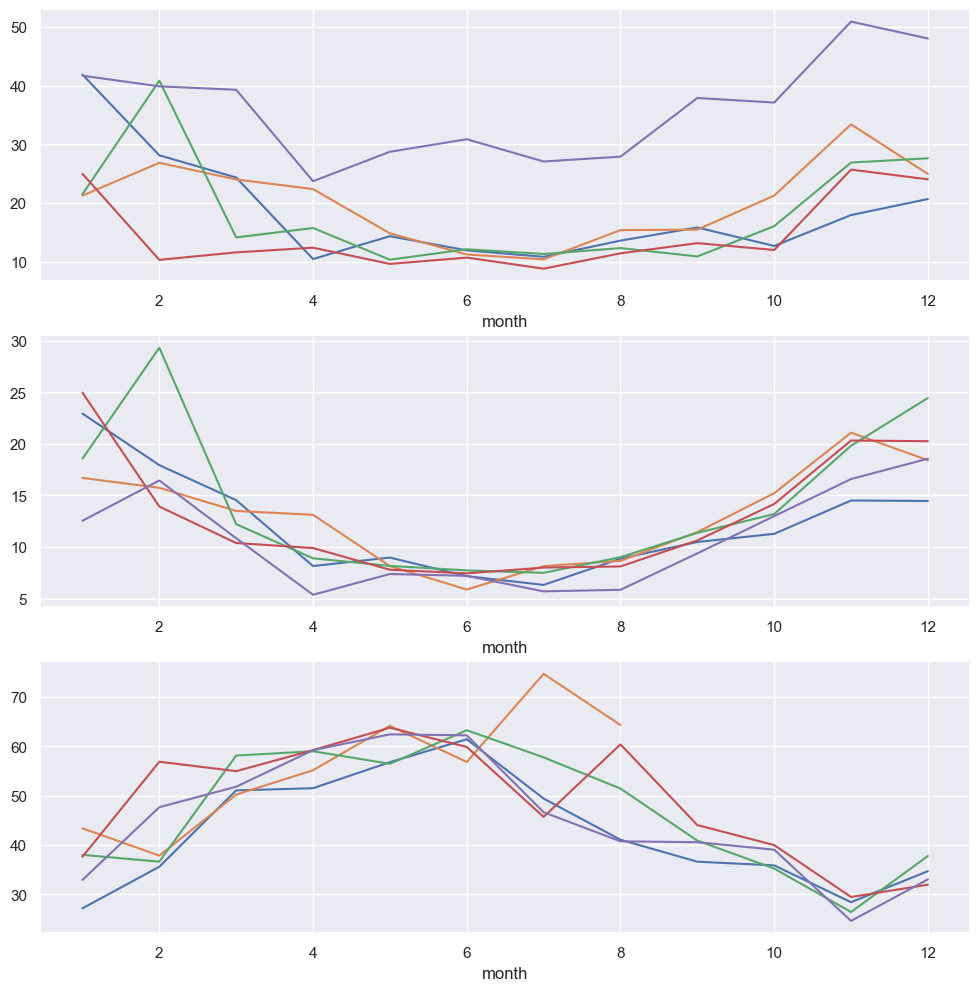

In [24]:
fig, ax=plt.subplots(nrows = 3, ncols=1, figsize=(12,12))

# find the last 5 years of which data is available
last = df_station1_daily[compound1].index.get_level_values('year').unique()[-5:]

# superimposed line plots for average of no_x
ax_combined1 = df_station1_monthly[compound1][last[0]].plot(ax=ax[0])
df_station1_monthly[compound1][last[1]].plot(ax=ax_combined1)
df_station1_monthly[compound1][last[2]].plot(ax=ax_combined1)
df_station1_monthly[compound1][last[3]].plot(ax=ax_combined1)
df_station1_monthly[compound1][last[4]].plot(ax=ax_combined1)

# superimposed line plots for average of pm_10
ax_combined2 = df_station2_monthly[compound2][last[0]].plot(ax=ax[1])
df_station2_monthly[compound2][last[1]].plot(ax=ax_combined2)
df_station2_monthly[compound2][last[2]].plot(ax=ax_combined2)
df_station2_monthly[compound2][last[3]].plot(ax=ax_combined2)
df_station2_monthly[compound2][last[4]].plot(ax=ax_combined2)

# superimposed line plots for average of wind_speed
ax_combined3 = df_station3_monthly[compound3][last[0]].plot(ax=ax[2])
df_station3_monthly[compound3][last[1]].plot(ax=ax_combined3)
df_station3_monthly[compound3][last[2]].plot(ax=ax_combined3)
df_station3_monthly[compound3][last[3]].plot(ax=ax_combined3)
df_station3_monthly[compound3][last[4]].plot(ax=ax_combined3)

;

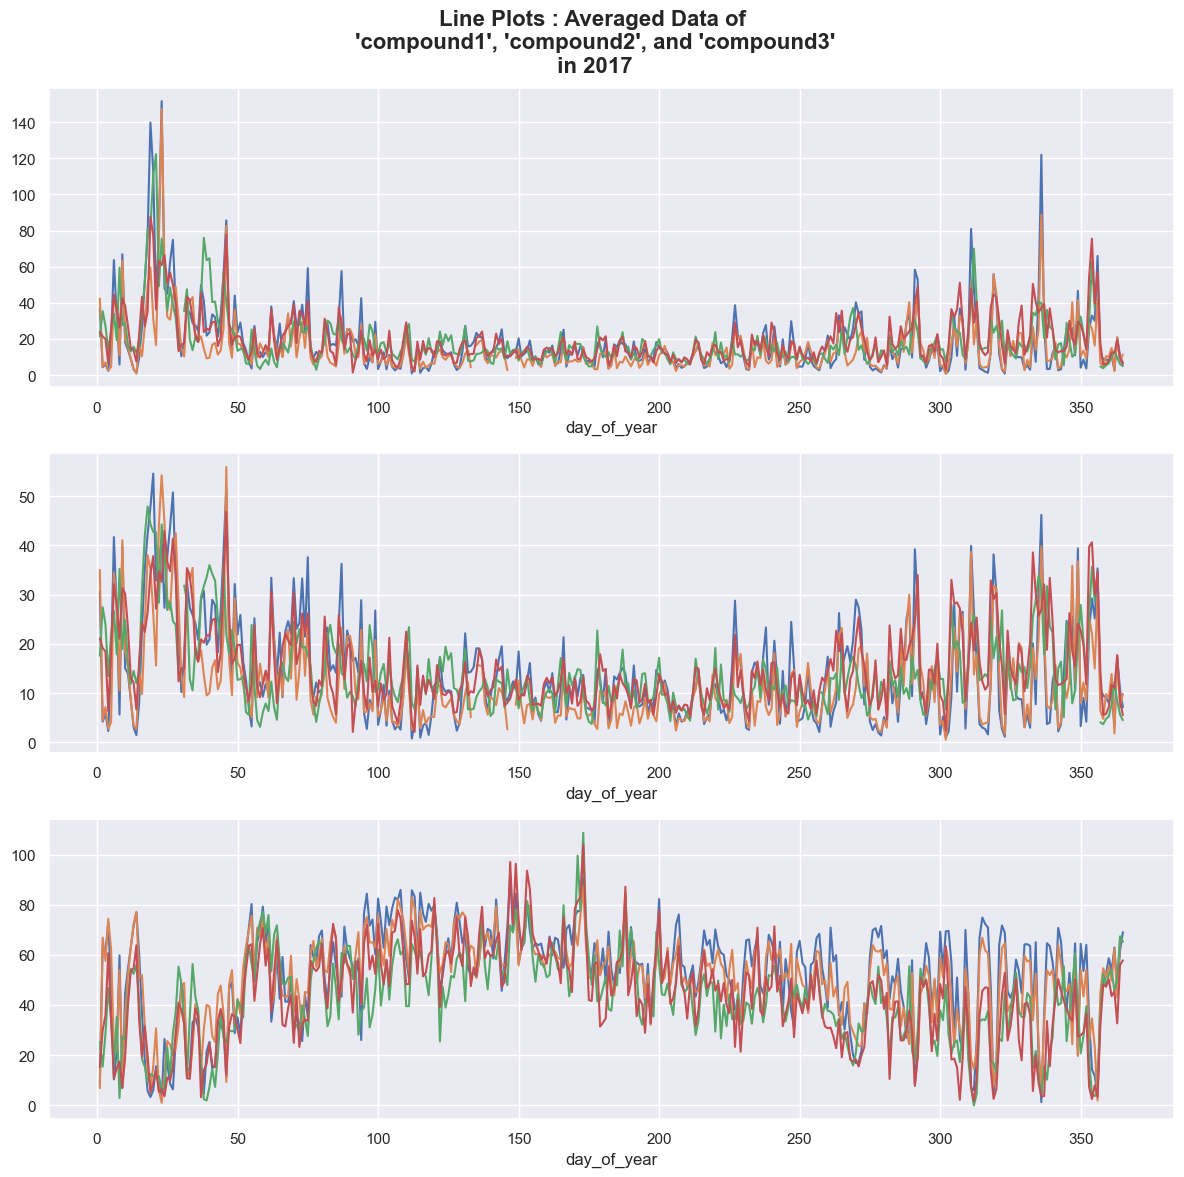

In [25]:
fig, ax=plt.subplots(nrows = 3, ncols=1, figsize=(12,12))

# superimposed line plots for average of no_x
df_station1_daily[compound1][2017].plot(ax=ax[0])
df_station2_daily[compound1][2017].plot(ax=ax[0])
df_station3_daily[compound1][2017].plot(ax=ax[0])
df_station4_daily[compound1][2017].plot(ax=ax[0])

# superimposed line plots for average of no_2
df_station1_daily[compound2][2017].plot(ax=ax[1])
df_station2_daily[compound2][2017].plot(ax=ax[1])
df_station3_daily[compound2][2017].plot(ax=ax[1])
df_station4_daily[compound2][2017].plot(ax=ax[1])

# superimposed line plots for average of o_3
df_station1_daily[compound3][2017].plot(ax=ax[2])
df_station2_daily[compound3][2017].plot(ax=ax[2])
df_station3_daily[compound3][2017].plot(ax=ax[2])
df_station4_daily[compound3][2017].plot(ax=ax[2])

# add titles
plt.suptitle("Line Plots : Averaged Data of\n 'compound1', 'compound2', and 'compound3'\n in 2017", fontsize=16, weight='bold');

plt.tight_layout();

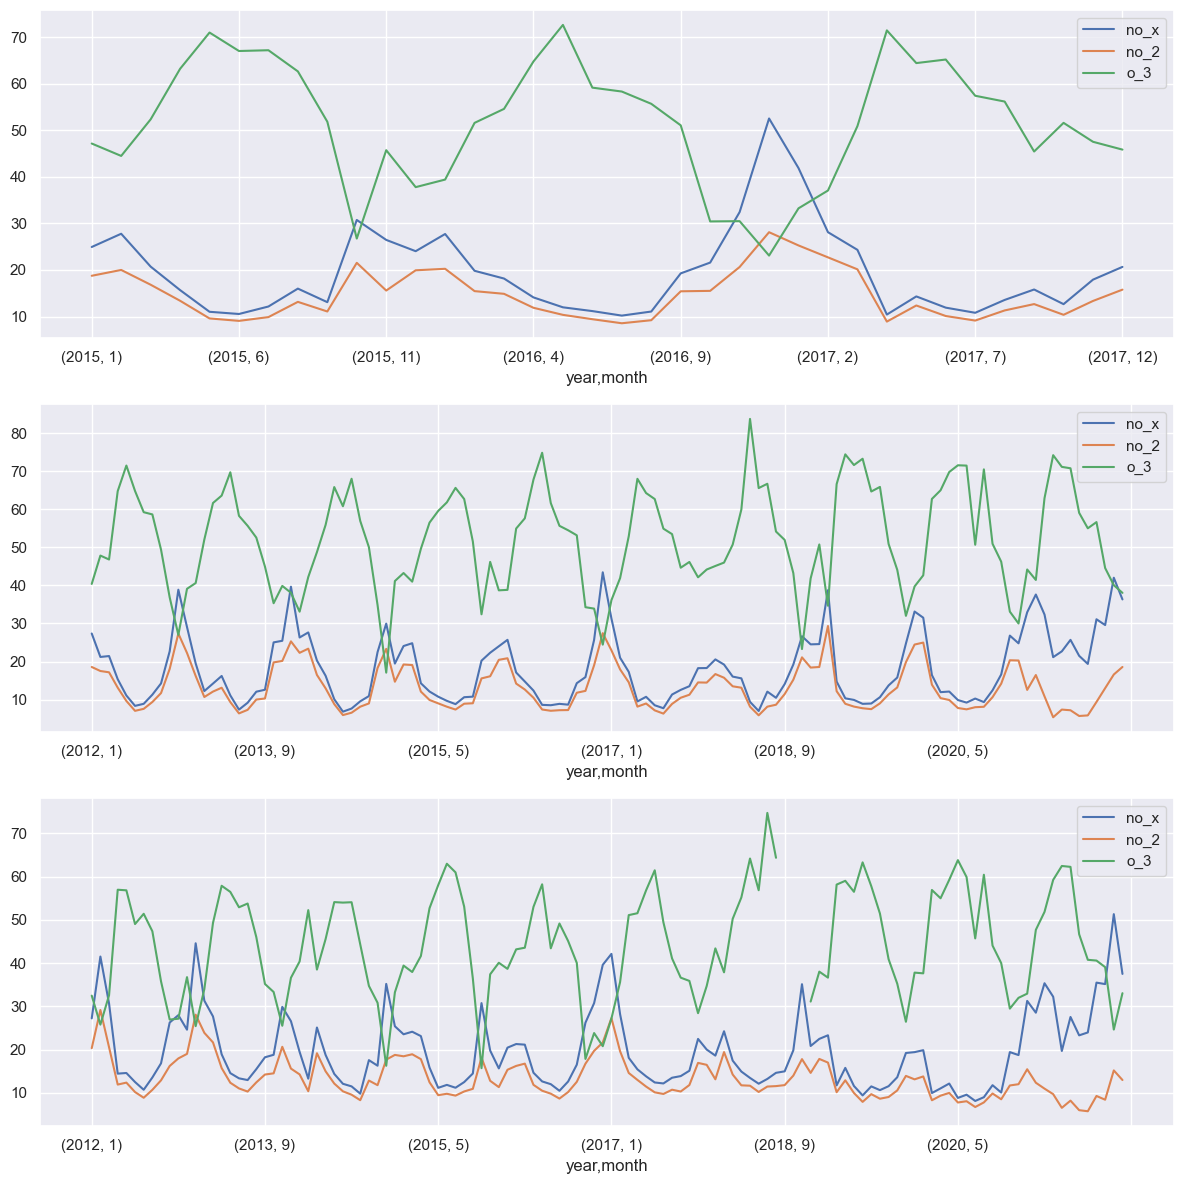

In [26]:
# location wise line plot

fig, ax =plt.subplots(nrows = 3, ncols=1, figsize=(12,12))

df_station1_loctemp = df_station1_monthly.loc[2015:2017]
df_station1_loctemp.plot(y='no_x', ax = ax[0])
df_station1_loctemp.plot(y='no_2', ax = ax[0])
df_station1_loctemp.plot(y='o_3', ax = ax[0])

df_station2_monthly.plot(y='no_x', ax = ax[1])
df_station2_monthly.plot(y='no_2', ax = ax[1])
df_station2_monthly.plot(y='o_3', ax = ax[1])

df_station3_monthly.plot(y='no_x', ax = ax[2])
df_station3_monthly.plot(y='no_2', ax = ax[2])
df_station3_monthly.plot(y='o_3', ax = ax[2])


plt.tight_layout();

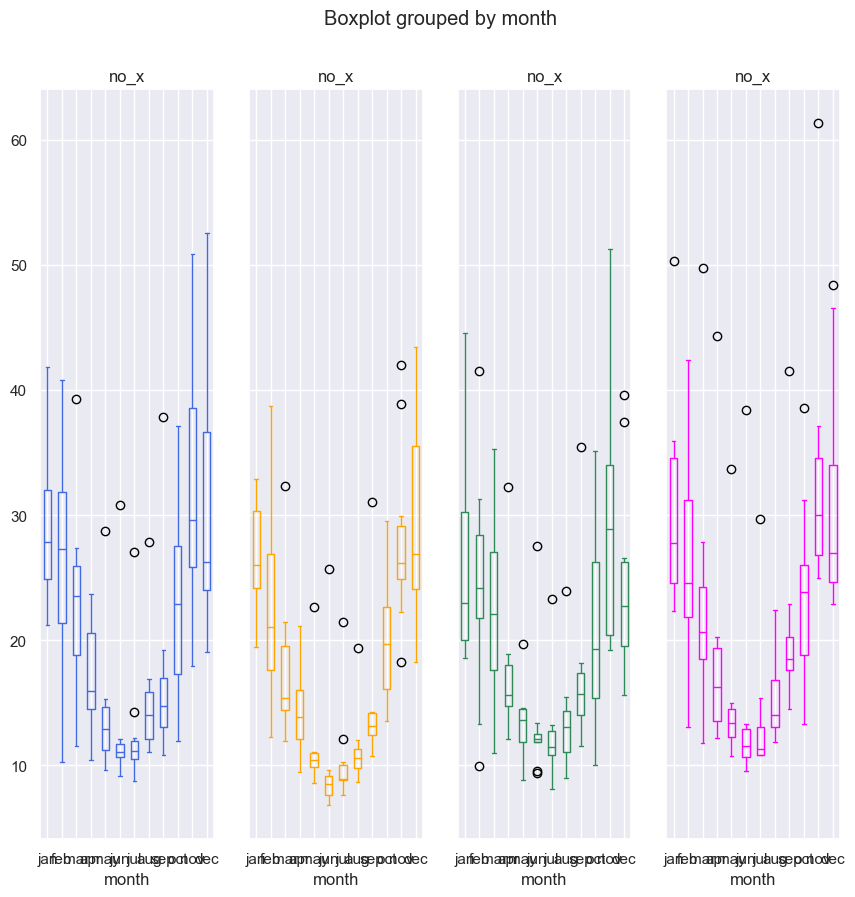

In [27]:
# box plots location wise (with one compound)
fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(10,10))
df_station1_monthly.boxplot(column=compound1, by='month', color='royalblue', ax=ax[0])
df_station2_monthly.boxplot(column=compound1, by='month', color='orange', ax=ax[1])
df_station3_monthly.boxplot(column=compound1, by='month', color='seagreen', ax=ax[2])
df_station4_monthly.boxplot(column=compound1, by='month', color='magenta', ax=ax[3])

# rearranged the x ticks for improved readability
xticklab = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
ax[0].set_xticks(range(1,13), xticklab);

## QUAN'S PLOTS

Generating four heatmaps ***(Nitrogen Dioxide And Wind Speed)*** for each air quality station.

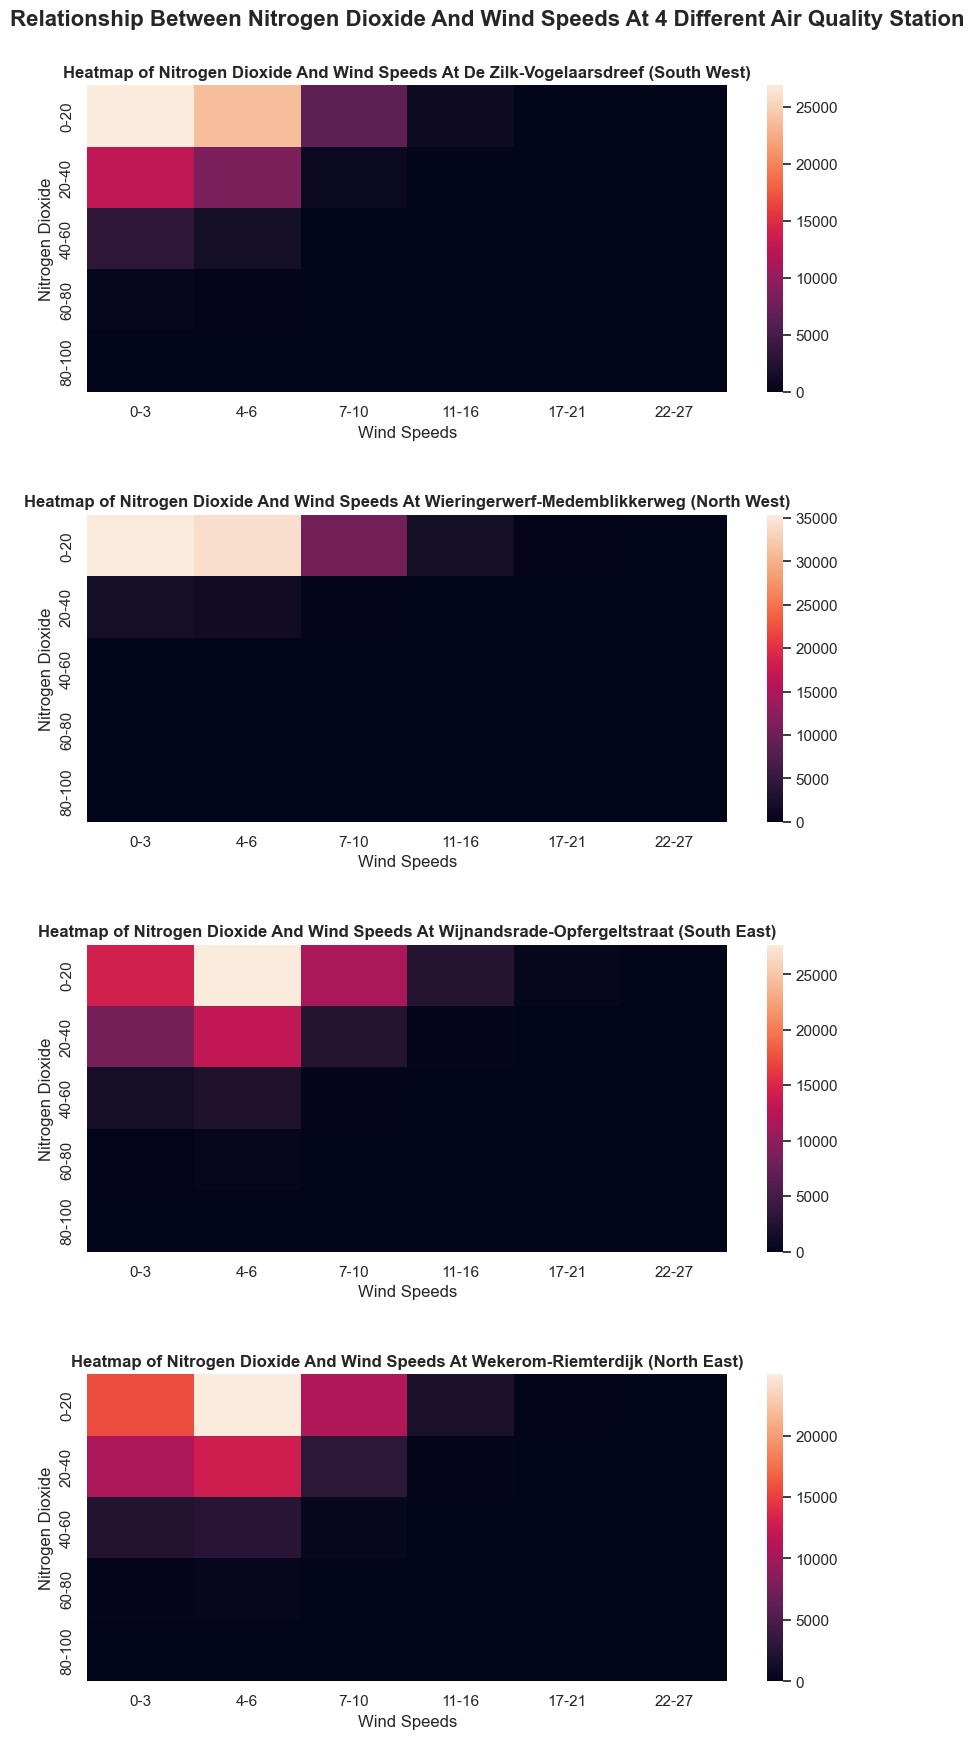

In [28]:
# HEATMAPS OF NO2 AND WIND SPEEDS AT 4 DIFFERENT AIR QUALITY STATIONS

fig, ax = plt.subplots(nrows = 4, ncols=1, figsize=(10,19))

# wind_speed 0 -> 20
# nh_3 0 -> 30

#aq_station_code_1 = 'NL10444'
#aq_station_code_2 = 'NL10538'
#aq_station_code_3 = 'NL10133'
#aq_station_code_4 = 'NL10738'

wind_speed_levels = ['0-3','4-6','7-10', '11-16','17-21','22-27']
no_levels = ['0-20','20-40','40-60','60-80','80-100']

# Dividing the compound and wind into bins based on their values 
df_station1['no_2_levels'] = pd.cut(df_station1['no_2'], len(no_levels), labels = no_levels)
df_station1['wind_speed_levels'] = pd.cut(df_station1['wind_speed'], len(wind_speed_levels), labels = wind_speed_levels)

df_station2['no_2_levels'] = pd.cut(df_station2['no_2'], len(no_levels), labels = no_levels)
df_station2['wind_speed_levels'] = pd.cut(df_station2['wind_speed'], len(wind_speed_levels), labels = wind_speed_levels)

df_station3['no_2_levels'] = pd.cut(df_station3['no_2'], len(no_levels), labels = no_levels)
df_station3['wind_speed_levels'] = pd.cut(df_station3['wind_speed'], len(wind_speed_levels), labels = wind_speed_levels)

df_station4['no_2_levels'] = pd.cut(df_station4['no_2'], len(no_levels), labels = no_levels)
df_station4['wind_speed_levels'] = pd.cut(df_station4['wind_speed'], len(wind_speed_levels), labels = wind_speed_levels)

# Grouping based on bins and count the occurences of the desired compound
df_station1_no_2_data = df_station1.groupby(['no_2_levels','wind_speed_levels'])['no_2'].count()
df_station2_no_2_data = df_station2.groupby(['no_2_levels','wind_speed_levels'])['no_2'].count()
df_station3_no_2_data = df_station3.groupby(['no_2_levels','wind_speed_levels'])['no_2'].count()
df_station4_no_2_data = df_station4.groupby(['no_2_levels','wind_speed_levels'])['no_2'].count()

# Transform Data into Matrix Shape
df_station1_no_2_matrix = df_station1_no_2_data.unstack()
df_station2_no_2_matrix = df_station2_no_2_data.unstack()
df_station3_no_2_matrix = df_station3_no_2_data.unstack()
df_station4_no_2_matrix = df_station4_no_2_data.unstack()

# Plot the heatmaps
sns.heatmap(data = df_station1_no_2_matrix, ax = ax[0])
sns.heatmap(data = df_station2_no_2_matrix, ax = ax[1])
sns.heatmap(data = df_station3_no_2_matrix, ax = ax[2])
sns.heatmap(data = df_station4_no_2_matrix, ax = ax[3])

# Setting Titles, X-Labels, Y-Labels
ax[0].set_title('Heatmap of Nitrogen Dioxide And Wind Speeds At De Zilk-Vogelaarsdreef (South West)', weight = 'bold')
ax[0].set_xlabel('Wind Speeds')
ax[0].set_ylabel('Nitrogen Dioxide')

ax[1].set_title('Heatmap of Nitrogen Dioxide And Wind Speeds At Wieringerwerf-Medemblikkerweg (North West)', weight = 'bold')
ax[1].set_xlabel('Wind Speeds')
ax[1].set_ylabel('Nitrogen Dioxide')

ax[2].set_title('Heatmap of Nitrogen Dioxide And Wind Speeds At Wijnandsrade-Opfergeltstraat (South East)', weight = 'bold')
ax[2].set_xlabel('Wind Speeds')
ax[2].set_ylabel('Nitrogen Dioxide')

ax[3].set_title('Heatmap of Nitrogen Dioxide And Wind Speeds At Wekerom-Riemterdijk (North East)', weight = 'bold')
ax[3].set_xlabel('Wind Speeds')
ax[3].set_ylabel('Nitrogen Dioxide')

# Styling the graphs
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.94, 
                    wspace=0.3, 
                    hspace=0.4)

plt.suptitle("Relationship Between Nitrogen Dioxide And Wind Speeds At 4 Different Air Quality Station", weight = 'bold', size = 16);

### INTERPRETATION

- Out of the 4 locations, the North West weather station has the lowest concentration of NO_2, while having low wind speeds.

- The 2 stations in the West (closer to the sea) see lower NO_2 density compared to the ones on the East (further from the sea) with the squares on the 0 - 20 row having brighter colors.

- The 2 stations in the East have higher variability in both NO_2 concentration and wind speeds with more cells being differently colored, but they have higher wind speeds occuring.

- The West stations definitely have lower NO_2 levels compared to the East ones, but their correlation to the wind speed is unclear.

Generating four scatterplots ***(Nitrogen Dioxide And Wind Gust)*** for each air quality station.

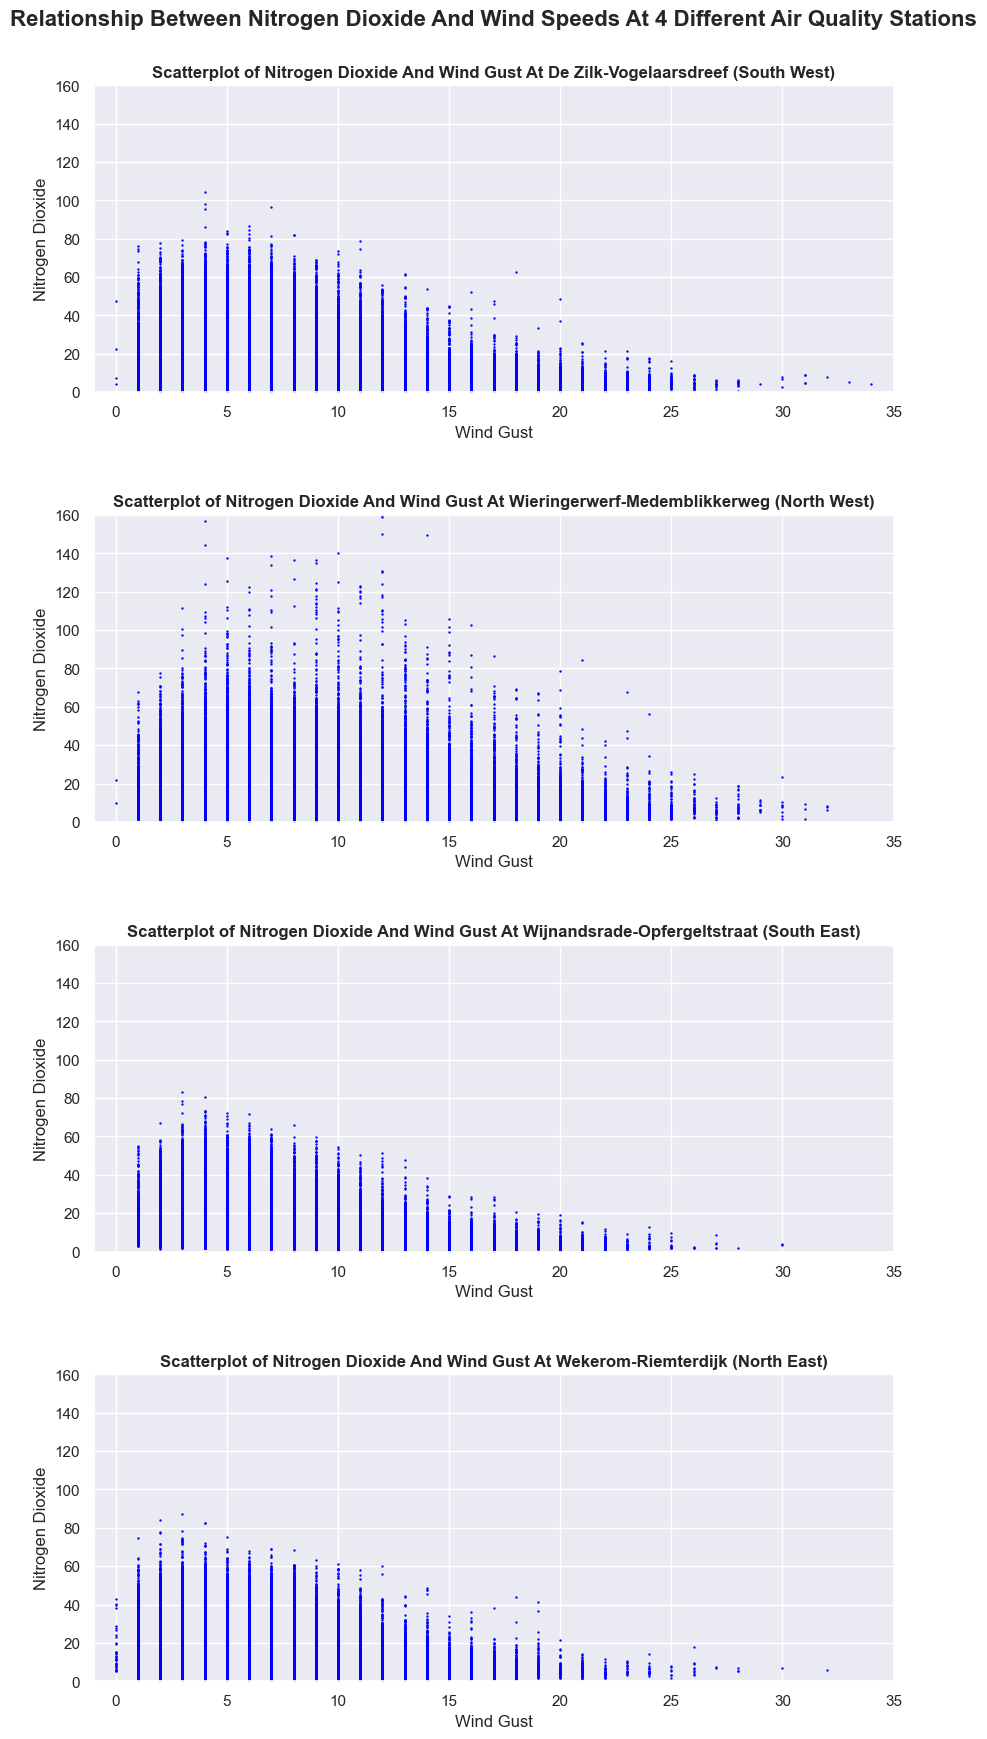

In [29]:
# SCATTERPLOTS OF NO2 AND WIND GUSTS AT 4 AIR QUALITY STATIONS
fig, ax = plt.subplots(nrows = 4, ncols=1, figsize=(10,19))

# Making the Scatterplots
df_station1.plot(kind = 'scatter', x = 'wind_gust', y = 'no_2',color = 'blue', s = 0.5, ax = ax[0])
df_station2.plot(kind = 'scatter', x = 'wind_gust', y = 'no_2',color = 'blue', s = 0.5, ax = ax[1])
df_station3.plot(kind = 'scatter', x = 'wind_gust', y = 'no_2',color = 'blue', s = 0.5, ax = ax[2])
df_station4.plot(kind = 'scatter', x = 'wind_gust', y = 'no_2',color = 'blue', s = 0.5, ax = ax[3])

# Labelling stuff
ax[0].set_xlim(-1, 35)
ax[0].set_ylim(0,160)
ax[0].set_xlabel('Wind Gust')
ax[0].set_ylabel('Nitrogen Dioxide')
ax[0].set_title('Scatterplot of Nitrogen Dioxide And Wind Gust At De Zilk-Vogelaarsdreef (South West)', weight = 'bold')

ax[1].set_xlim(-1, 35)
ax[1].set_ylim(0,160)
ax[1].set_xlabel('Wind Gust')
ax[1].set_ylabel('Nitrogen Dioxide')
ax[1].set_title('Scatterplot of Nitrogen Dioxide And Wind Gust At Wieringerwerf-Medemblikkerweg (North West)', weight = 'bold')

ax[2].set_xlim(-1, 35)
ax[2].set_ylim(0,160)
ax[2].set_xlabel('Wind Gust')
ax[2].set_ylabel('Nitrogen Dioxide')
ax[2].set_title('Scatterplot of Nitrogen Dioxide And Wind Gust At Wijnandsrade-Opfergeltstraat (South East)', weight = 'bold')

ax[3].set_xlim(-1, 35)
ax[3].set_ylim(0,160)
ax[3].set_xlabel('Wind Gust')
ax[3].set_ylabel('Nitrogen Dioxide')
ax[3].set_title('Scatterplot of Nitrogen Dioxide And Wind Gust At Wekerom-Riemterdijk (North East)', weight = 'bold')


# Styling the graphs
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.94, 
                    wspace=0.3, 
                    hspace=0.4)

plt.suptitle("Relationship Between Nitrogen Dioxide And Wind Speeds At 4 Different Air Quality Stations", weight = 'bold', size = 16);

### INTERPRETATION

- The 4 weather all follow a similar pattern: Higher wind gusts correlated with lower levels of nitrogen dioxide. The NO_2 levels started off low, peaking around wind gusts between 0 and 10 before dropping off as the wind gust values go up.
- The stations on the West recorded higher wind gusts (There are more values above 25) and have higher concentrations of NO_2 compared to the ones on the East.
- The places with higher wind gust seem to experience higher levels of NO 2.

## SZONJA'S PLOTS

In [30]:
df_station1_speed = df_station1.groupby(['wind_speed']).mean()
df_station2_speed = df_station2.groupby(['wind_speed']).mean()
df_station3_speed = df_station3.groupby(['wind_speed']).mean()
df_station4_speed = df_station4.groupby(['wind_speed']).mean()

df_station1_gust = df_station1.groupby(['wind_gust']).mean()
df_station2_gust = df_station2.groupby(['wind_gust']).mean()
df_station3_gust = df_station3.groupby(['wind_gust']).mean()
df_station4_gust = df_station4.groupby(['wind_gust']).mean()

C:\Users\quanb\AppData\Local\Temp\ipykernel_21424\3549181350.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_station1_speed = df_station1.groupby(['wind_speed']).mean()
C:\Users\quanb\AppData\Local\Temp\ipykernel_21424\3549181350.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_station2_speed = df_station2.groupby(['wind_speed']).mean()
C:\Users\quanb\AppData\Local\Temp\ipykernel_21424\3549181350.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only column

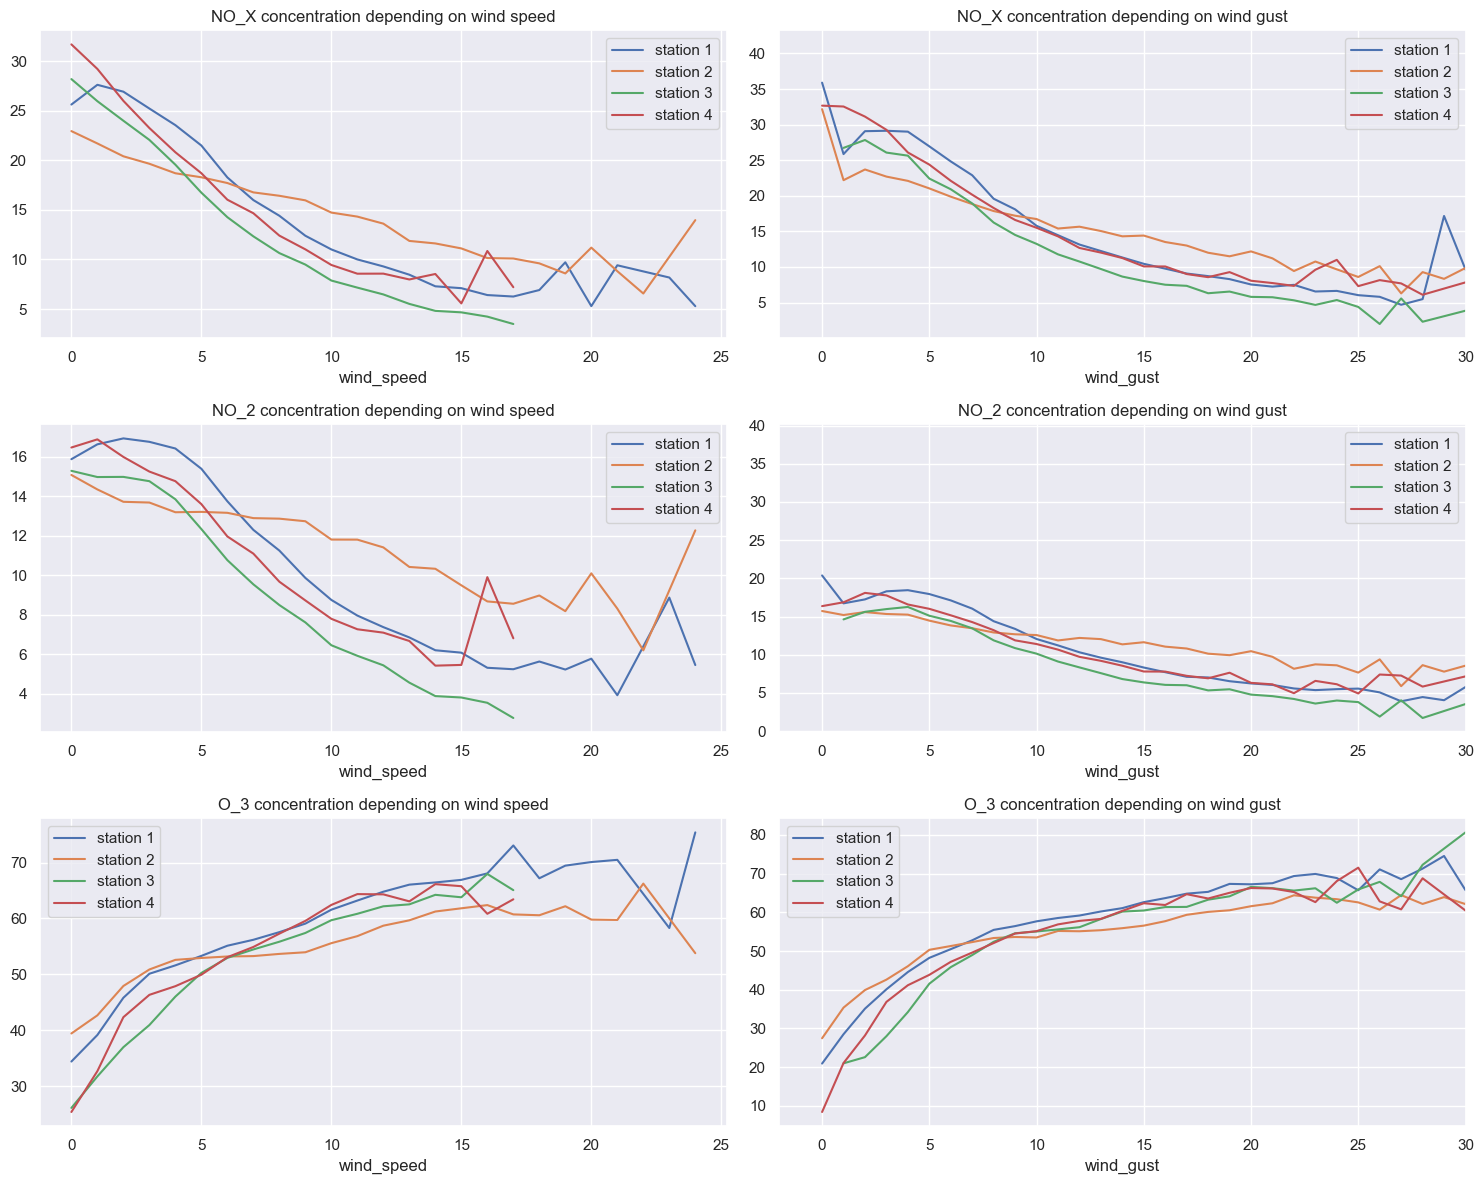

In [31]:
fig, ax = plt.subplots(nrows = 3, ncols=2, figsize=(15,12))
# concentration vs the windspeed

df_station1_speed.plot(y='no_x', ax=ax[0,0])
df_station2_speed.plot(y='no_x', ax=ax[0,0])
df_station3_speed.plot(y='no_x', ax=ax[0,0])
df_station4_speed.plot(y='no_x', ax=ax[0,0])

df_station1_gust.plot(y='no_x', ax=ax[0,1])
df_station2_gust.plot(y='no_x', ax=ax[0,1])
df_station3_gust.plot(y='no_x', ax=ax[0,1])
df_station4_gust.plot(y='no_x', ax=ax[0,1])

df_station1_speed.plot(y='no_2', ax=ax[1,0])
df_station2_speed.plot(y='no_2', ax=ax[1,0])
df_station3_speed.plot(y='no_2', ax=ax[1,0])
df_station4_speed.plot(y='no_2', ax=ax[1,0])

df_station1_gust.plot(y='no_2', ax=ax[1,1])
df_station2_gust.plot(y='no_2', ax=ax[1,1])
df_station3_gust.plot(y='no_2', ax=ax[1,1])
df_station4_gust.plot(y='no_2', ax=ax[1,1])

df_station1_speed.plot(y='o_3', ax=ax[2,0])
df_station2_speed.plot(y='o_3', ax=ax[2,0])
df_station3_speed.plot(y='o_3', ax=ax[2,0])
df_station4_speed.plot(y='o_3', ax=ax[2,0])

df_station1_gust.plot(y='o_3', ax=ax[2,1])
df_station2_gust.plot(y='o_3', ax=ax[2,1])
df_station3_gust.plot(y='o_3', ax=ax[2,1])
df_station4_gust.plot(y='o_3', ax=ax[2,1])


ax[0,0].legend(['station 1', 'station 2', 'station 3', 'station 4'])
ax[0,1].legend(['station 1', 'station 2', 'station 3', 'station 4'])
ax[1,0].legend(['station 1', 'station 2', 'station 3', 'station 4'])
ax[1,1].legend(['station 1', 'station 2', 'station 3', 'station 4'])
ax[2,0].legend(['station 1', 'station 2', 'station 3', 'station 4'])
ax[2,1].legend(['station 1', 'station 2', 'station 3', 'station 4'])


ax[0,0].set_title('NO_X concentration depending on wind speed')
ax[0,1].set_title('NO_X concentration depending on wind gust')
ax[1,0].set_title('NO_2 concentration depending on wind speed')
ax[1,1].set_title('NO_2 concentration depending on wind gust')
ax[2,0].set_title('O_3 concentration depending on wind speed')
ax[2,1].set_title('O_3 concentration depending on wind gust')

ax[0,1].set_xlim(-2,30)
ax[1,1].set_xlim(-2,30)
ax[2,1].set_xlim(-2,30)

plt.tight_layout();

### INTERPRETATION
In these plots it is seeable that with NO_X and NO_2 there is a negative correlation with wind speed and wind gust, on the other hand there is a positive correlation when ozone is compared. All four statetions are more or less showing the same lines

In [32]:
df_winds_1 = df_station1.groupby(['year','day_of_year']).mean()
df_winds_1 = df_winds_1.loc[2017:2017]
df_winds_2 = df_station2.groupby(['year','day_of_year']).mean()
df_winds_2 = df_winds_2.loc[2017:2017]
df_winds_3 = df_station3.groupby(['year','day_of_year']).mean()
df_winds_3 = df_winds_3.loc[2017:2017]
df_winds_4 = df_station4.groupby(['year','day_of_year']).mean()
df_winds_4 = df_winds_4.loc[2017:2017]

C:\Users\quanb\AppData\Local\Temp\ipykernel_21424\1866475055.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_winds_1 = df_station1.groupby(['year','day_of_year']).mean()
C:\Users\quanb\AppData\Local\Temp\ipykernel_21424\1866475055.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_winds_2 = df_station2.groupby(['year','day_of_year']).mean()
C:\Users\quanb\AppData\Local\Temp\ipykernel_21424\1866475055.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only colu

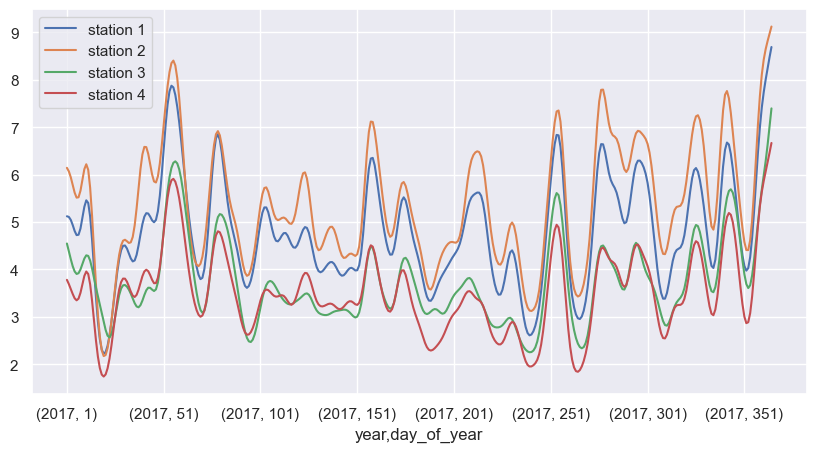

In [33]:
df_winds_1['filt_wind_speed'] = gaussian_filter1d(df_winds_1['wind_speed'] , sigma=3, mode='nearest')
df_winds_2['filt_wind_speed'] = gaussian_filter1d(df_winds_2['wind_speed'] , sigma=3, mode='nearest')
df_winds_3['filt_wind_speed'] = gaussian_filter1d(df_winds_3['wind_speed'] , sigma=3, mode='nearest')
df_winds_4['filt_wind_speed'] = gaussian_filter1d(df_winds_4['wind_speed'] , sigma=3, mode='nearest')

ax = df_winds_1.plot(y='filt_wind_speed')
df_winds_2.plot(y='filt_wind_speed', ax=ax)
df_winds_3.plot(y='filt_wind_speed', ax=ax)
df_winds_4.plot(y='filt_wind_speed', ax=ax)

ax.legend(['station 1', 'station 2', 'station 3', 'station 4']);

### INTERPRETATION
The plot shows that the coastal places, station 1 and station 2, is more windy than more eastern earas. The two coastal and two eatern places are moving together.

## PIM'S PLOTS

Text(0, 0.5, 'O_3')

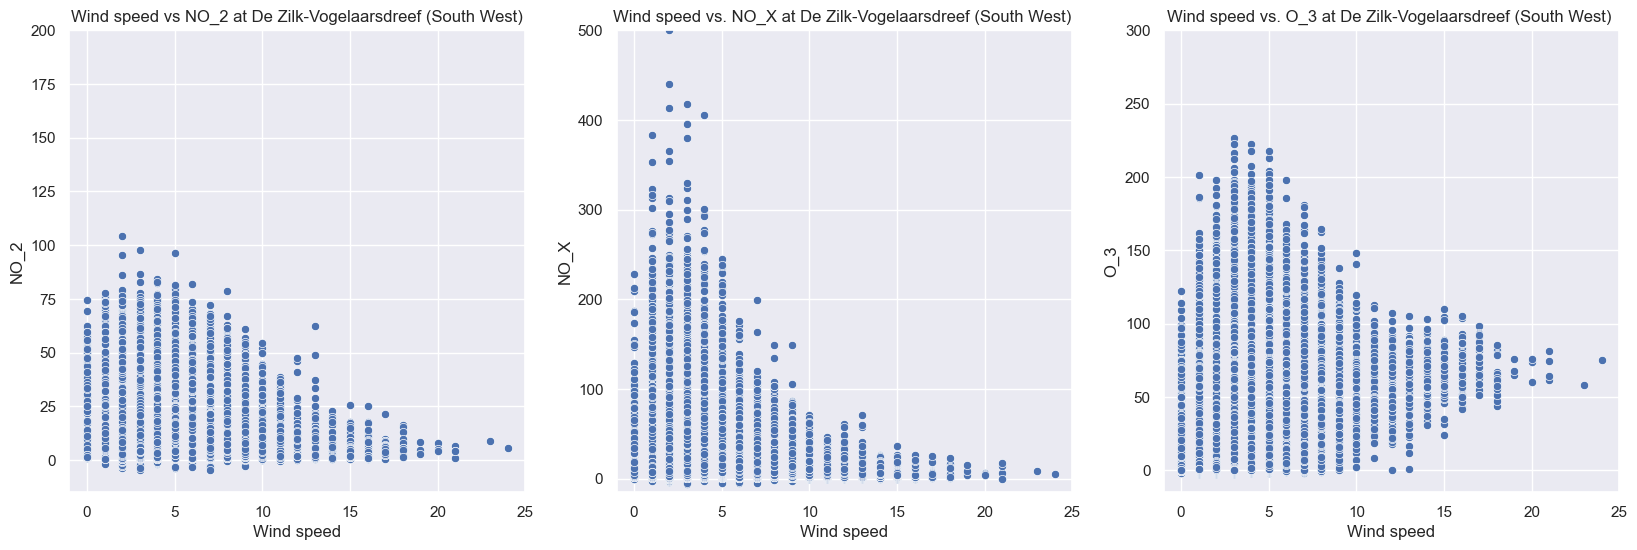

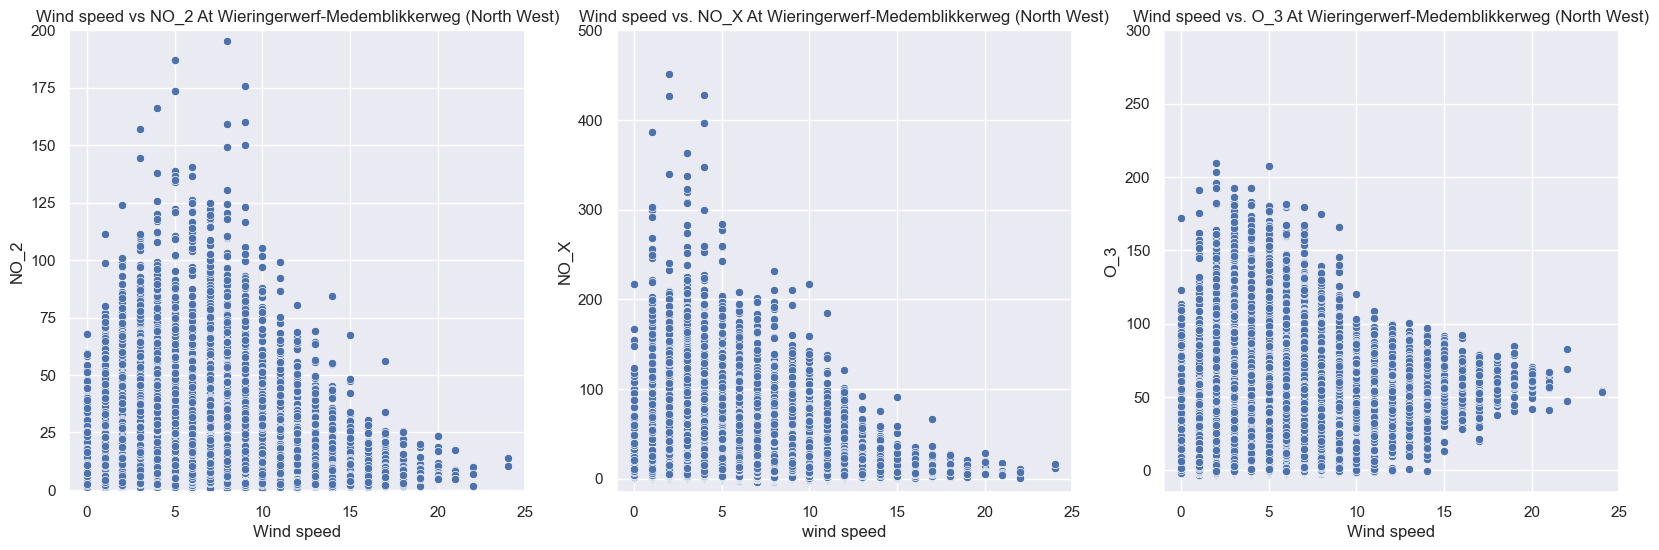

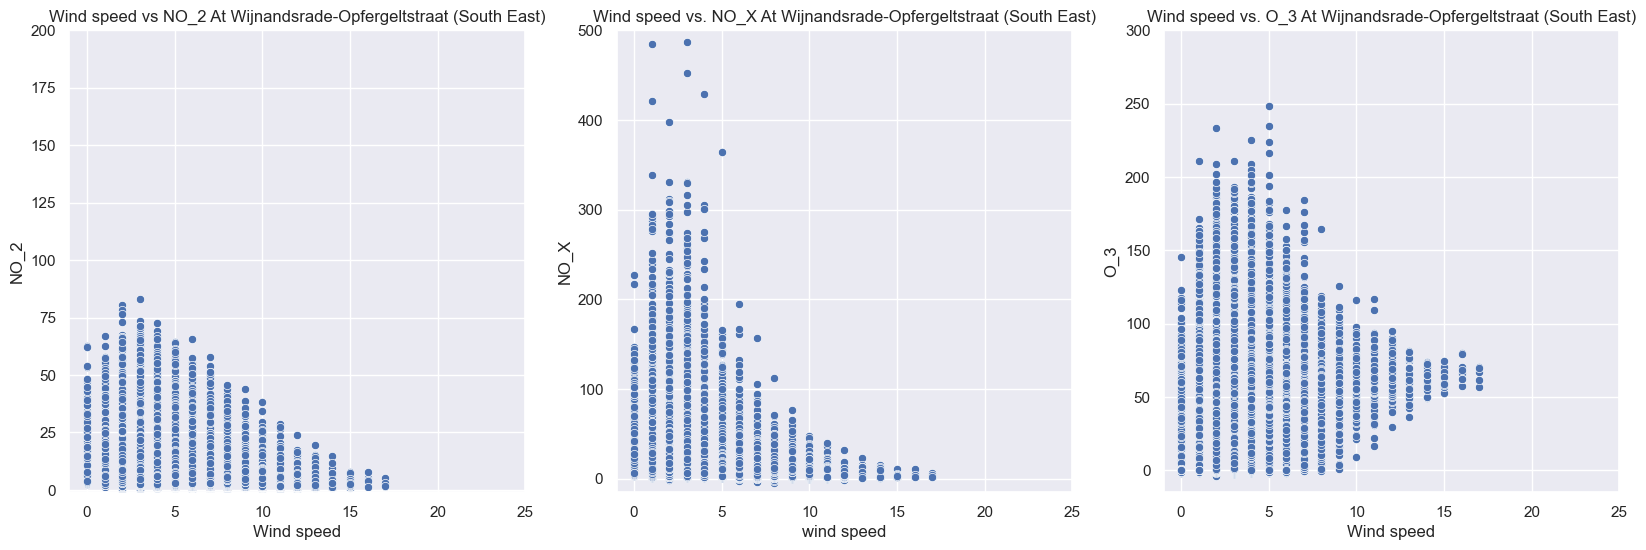

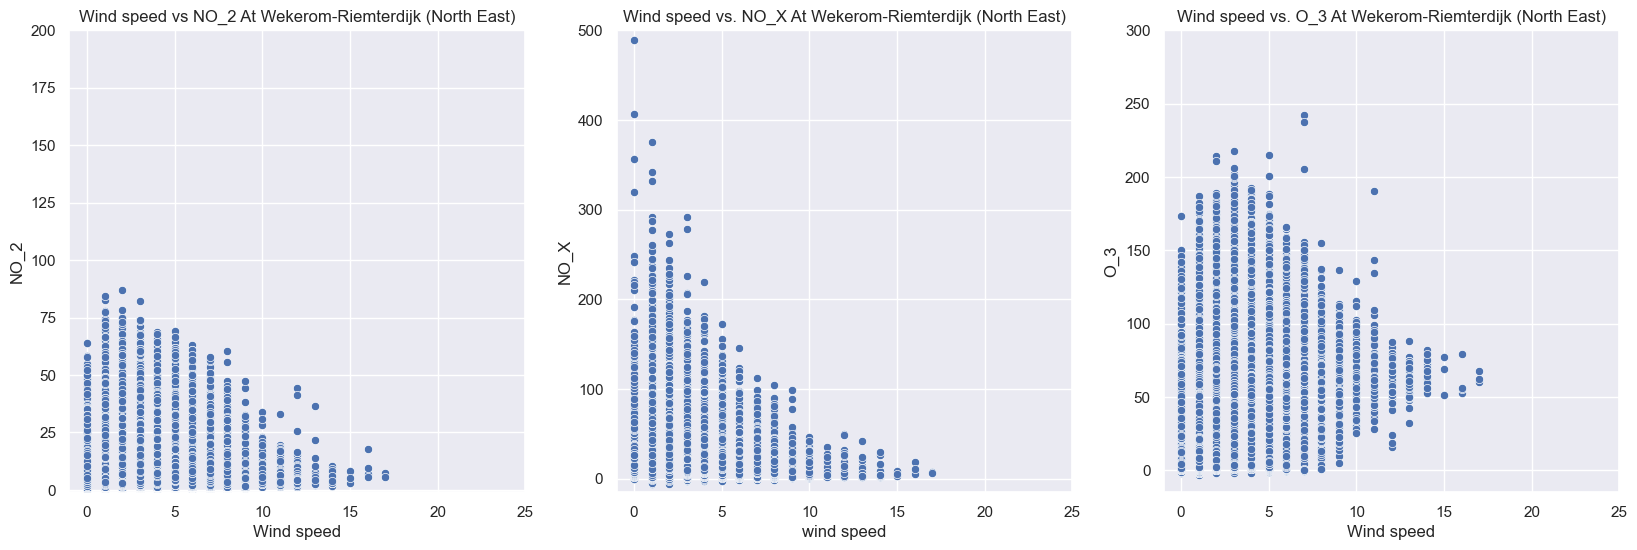

In [34]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x='wind_speed', y='no_2', data=df_station1)
plt.xlim(-1, 25) 
plt.ylim(-15, 200)
plt.title('Wind speed vs NO_2 at De Zilk-Vogelaarsdreef (South West)')
plt.xlabel('Wind speed')
plt.ylabel('NO_2')

plt.subplot(1, 3, 2)
sns.scatterplot(x='wind_speed', y='no_x', data=df_station1)
plt.xlim(-1, 25) 
plt.ylim(-15, 500)
plt.title('Wind speed vs. NO_X at De Zilk-Vogelaarsdreef (South West) ')
plt.xlabel('Wind speed')
plt.ylabel('NO_X')

plt.subplot(1, 3, 3)
sns.scatterplot(x='wind_speed', y='o_3', data=df_station1)
plt.xlim(-1, 25) 
plt.ylim(-15, 300)
plt.title('Wind speed vs. O_3 at De Zilk-Vogelaarsdreef (South West) ')
plt.xlabel('Wind speed')
plt.ylabel('O_3')



plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x='wind_speed', y='no_2', data=df_station2)
plt.xlim(-1, 25) 
plt.ylim(-1, 200)
plt.title('Wind speed vs NO_2 At Wieringerwerf-Medemblikkerweg (North West)')
plt.xlabel('Wind speed')
plt.ylabel('NO_2')

plt.subplot(1, 3, 2)
sns.scatterplot(x='wind_speed', y='no_x', data=df_station2)
plt.xlim(-1, 25) 
plt.ylim(-15, 500)
plt.title('Wind speed vs. NO_X At Wieringerwerf-Medemblikkerweg (North West)')
plt.xlabel('wind speed')
plt.ylabel('NO_X')

plt.subplot(1, 3, 3)
sns.scatterplot(x='wind_speed', y='o_3', data=df_station2)
plt.xlim(-1, 25) 
plt.ylim(-15, 300)
plt.title('Wind speed vs. O_3 At Wieringerwerf-Medemblikkerweg (North West)')
plt.xlabel('Wind speed')
plt.ylabel('O_3')


plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x='wind_speed', y='no_2', data=df_station3)
plt.xlim(-1, 25) 
plt.ylim(-1, 200)
plt.title('Wind speed vs NO_2 At Wijnandsrade-Opfergeltstraat (South East)')
plt.xlabel('Wind speed')
plt.ylabel('NO_2')

plt.subplot(1, 3, 2)
sns.scatterplot(x='wind_speed', y='no_x', data=df_station3)
plt.xlim(-1, 25) 
plt.ylim(-15, 500)
plt.title('Wind speed vs. NO_X At Wijnandsrade-Opfergeltstraat (South East)')
plt.xlabel('wind speed')
plt.ylabel('NO_X')

plt.subplot(1, 3, 3)
sns.scatterplot(x='wind_speed', y='o_3', data=df_station3)
plt.xlim(-1, 25) 
plt.ylim(-15, 300)
plt.title('Wind speed vs. O_3 At Wijnandsrade-Opfergeltstraat (South East)')
plt.xlabel('Wind speed')
plt.ylabel('O_3')

plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x='wind_speed', y='no_2', data=df_station4)
plt.xlim(-1, 25) 
plt.ylim(-1, 200)
plt.title('Wind speed vs NO_2 At Wekerom-Riemterdijk (North East)')
plt.xlabel('Wind speed')
plt.ylabel('NO_2')

plt.subplot(1, 3, 2)
sns.scatterplot(x='wind_speed', y='no_x', data=df_station4)
plt.xlim(-1, 25) 
plt.ylim(-15, 500)
plt.title('Wind speed vs. NO_X At Wekerom-Riemterdijk (North East)')
plt.xlabel('wind speed')
plt.ylabel('NO_X')

plt.subplot(1, 3, 3)
sns.scatterplot(x='wind_speed', y='o_3', data=df_station4)
plt.xlim(-1, 25) 
plt.ylim(-15, 300)
plt.title('Wind speed vs. O_3 At Wekerom-Riemterdijk (North East)')
plt.xlabel('Wind speed')
plt.ylabel('O_3')

## INTERPRETATION
first you see that in all the scatter plots there is a negative relation between the wind speed and the No2 and the Nox

in the scatter plots of NO2 you can see that especcially in the north west there is a much higher concentration NO2 in the air. but also in the south west there is a little higher concentration than in the east part of the netherlands. the seaside and the big cities like Amsterdam and Rotterdam will most likely be the main reason for this difference.

in the scatter plots of NOX you see kind of the same trends although the difference is here bigger in the windspeed of 5-15 area and the difference is smaller in the lower wind speed area.

the scatterplots of the O3 are actually a bit different and you dont see a strong negative relation between the 2 factors. next to that you see that the wind speed at the 2 west stations goes further than the wind speed at the east stations. from there you can say that thats the seaside

Text(788.8409090909089, 0.5, 'O3')

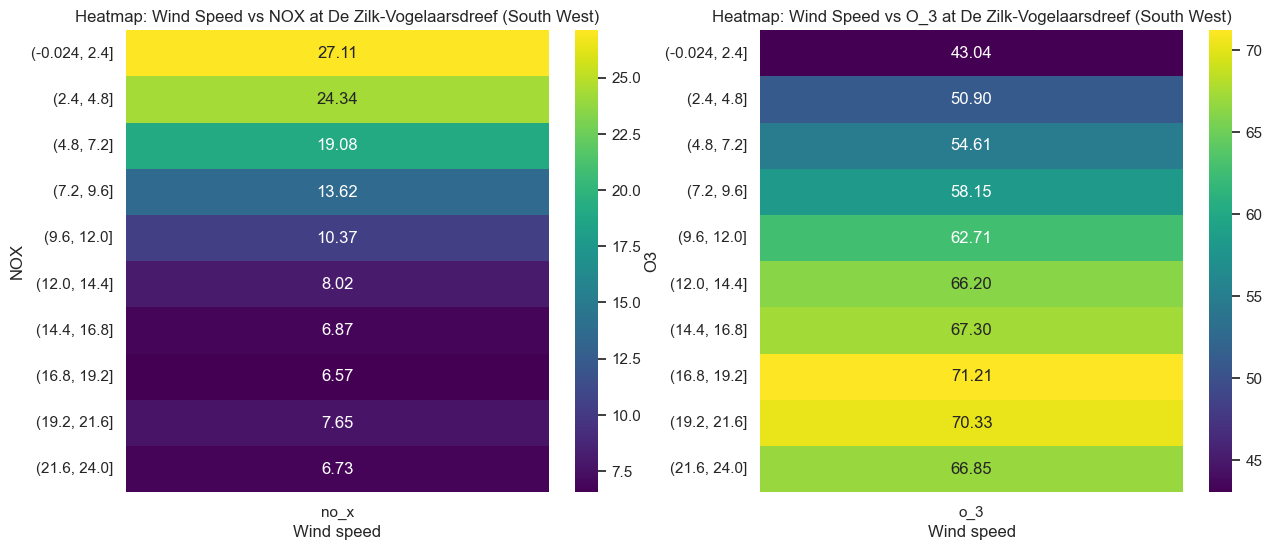

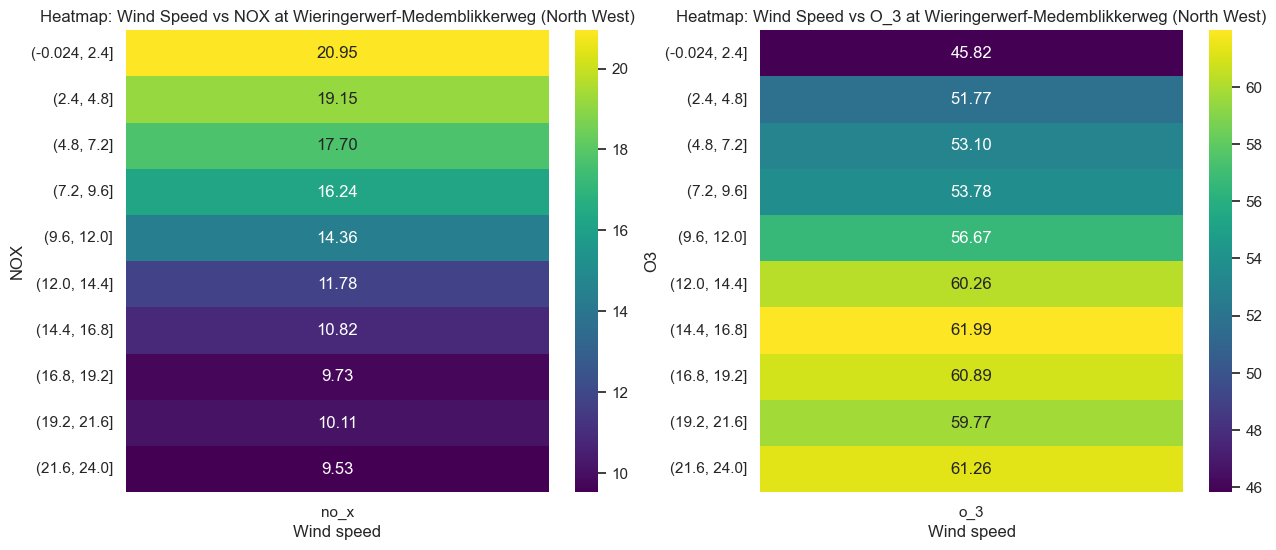

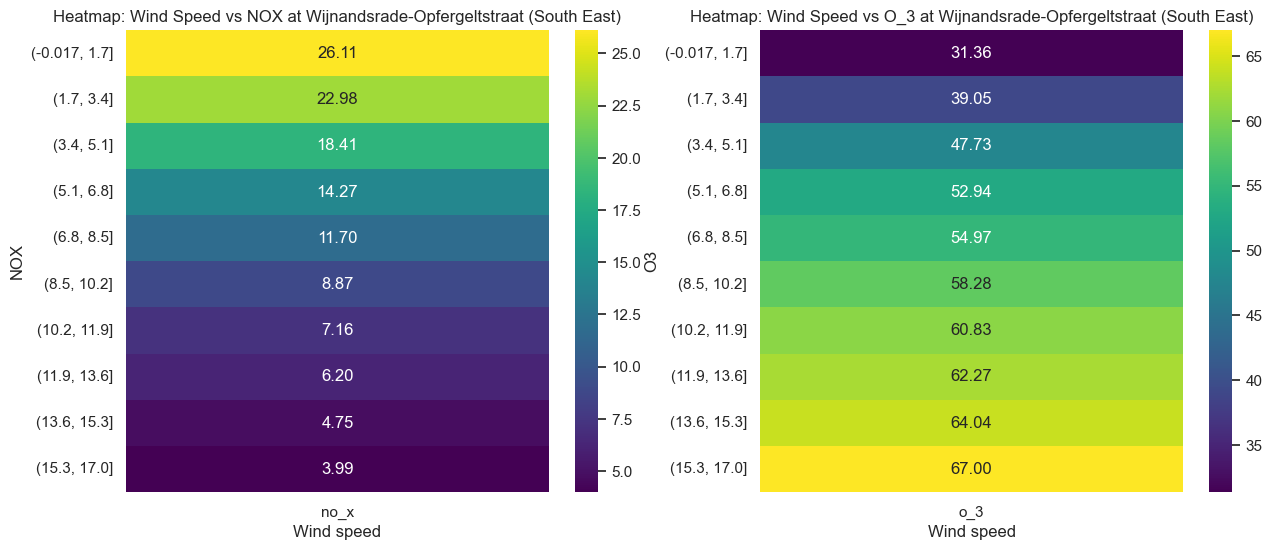

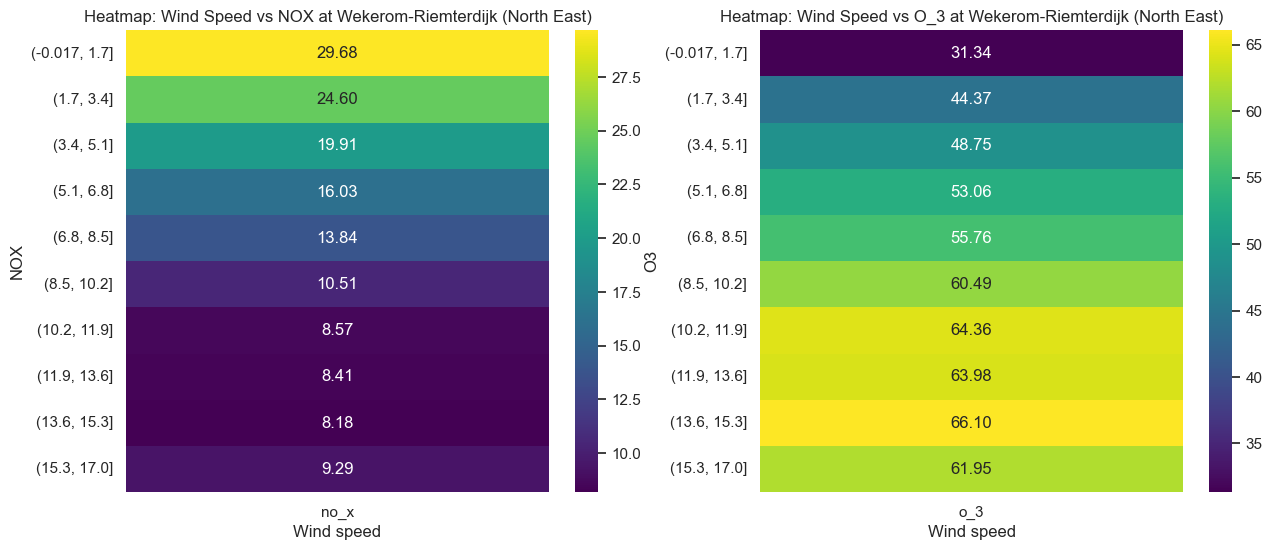

In [35]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
heatmap_data_no_x = pd.pivot_table(df_station1, values='no_x', index=pd.cut(df_station1['wind_speed'], bins=10), aggfunc='mean')
sns.heatmap(heatmap_data_no_x, cmap='viridis', annot=True, fmt=".2f")
plt.title('Heatmap: Wind Speed vs NOX at De Zilk-Vogelaarsdreef (South West)')
plt.xlabel('Wind speed')
plt.ylabel('NOX')

plt.subplot(1, 2, 2)
heatmap_data_no_x = pd.pivot_table(df_station1, values='o_3', index=pd.cut(df_station1['wind_speed'], bins=10), aggfunc='mean')
sns.heatmap(heatmap_data_no_x, cmap='viridis', annot=True, fmt=".2f")
plt.title('Heatmap: Wind Speed vs O_3 at De Zilk-Vogelaarsdreef (South West)')
plt.xlabel('Wind speed')
plt.ylabel('O3')


plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
heatmap_data_no_x = pd.pivot_table(df_station2, values='no_x', index=pd.cut(df_station2['wind_speed'], bins=10), aggfunc='mean')
sns.heatmap(heatmap_data_no_x, cmap='viridis', annot=True, fmt=".2f")
plt.title('Heatmap: Wind Speed vs NOX at Wieringerwerf-Medemblikkerweg (North West)')
plt.xlabel('Wind speed')
plt.ylabel('NOX')

plt.subplot(1, 2, 2)
heatmap_data_no_x = pd.pivot_table(df_station2, values='o_3', index=pd.cut(df_station2['wind_speed'], bins=10), aggfunc='mean')
sns.heatmap(heatmap_data_no_x, cmap='viridis', annot=True, fmt=".2f")
plt.title('Heatmap: Wind Speed vs O_3 at Wieringerwerf-Medemblikkerweg (North West)')
plt.xlabel('Wind speed')
plt.ylabel('O3')

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
heatmap_data_no_x = pd.pivot_table(df_station3, values='no_x', index=pd.cut(df_station3['wind_speed'], bins=10), aggfunc='mean')
sns.heatmap(heatmap_data_no_x, cmap='viridis', annot=True, fmt=".2f")
plt.title('Heatmap: Wind Speed vs NOX at Wijnandsrade-Opfergeltstraat (South East)')
plt.xlabel('Wind speed')
plt.ylabel('NOX')

plt.subplot(1, 2, 2)
heatmap_data_no_x = pd.pivot_table(df_station3, values='o_3', index=pd.cut(df_station3['wind_speed'], bins=10), aggfunc='mean')
sns.heatmap(heatmap_data_no_x, cmap='viridis', annot=True, fmt=".2f")
plt.title('Heatmap: Wind Speed vs O_3 at Wijnandsrade-Opfergeltstraat (South East)')
plt.xlabel('Wind speed')
plt.ylabel('O3')

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
heatmap_data_no_x = pd.pivot_table(df_station4, values='no_x', index=pd.cut(df_station4['wind_speed'], bins=10), aggfunc='mean')
sns.heatmap(heatmap_data_no_x, cmap='viridis', annot=True, fmt=".2f")
plt.title('Heatmap: Wind Speed vs NOX at Wekerom-Riemterdijk (North East)')
plt.xlabel('Wind speed')
plt.ylabel('NOX')

plt.subplot(1, 2, 2)
heatmap_data_no_x = pd.pivot_table(df_station4, values='o_3', index=pd.cut(df_station4['wind_speed'], bins=10), aggfunc='mean')
sns.heatmap(heatmap_data_no_x, cmap='viridis', annot=True, fmt=".2f")
plt.title('Heatmap: Wind Speed vs O_3 at Wekerom-Riemterdijk (North East)')
plt.xlabel('Wind speed')
plt.ylabel('O3')

## INTERPRETATION
to be honest there is not big of a difference between the stations to show in this NOX heatmaps. there are some small differences but no real patterns where you can see if it depends on north-south or east-west. you can see that they are as well negative related to eachother but there are no big differences between the stations

on the other hand you can see a big difference between the heatplots of NOX and O3 where its completly the other way around.

### HYP

• One-sided or two-sided?

• One-sample or two-sample?

• Equality of means or equality of proportions?

• What is your null hypothesis and what is your alternative hypothesis?

• What level of significance are you using?

• What assumptions do you (need to) make?

## Part 4. Polishing and pitching results

This section is only for generating figures if you need it. You may leave it empty.

# Feedback

Please fill in this questionaire to help us improve this course for the next year. Your feedback will be anonymized and will not affect your grade in any way!

### How many hours did you spend on these exercises?

Assign a number to `feedback_time`.

In [36]:
#// BEGIN_FEEDBACK [Feedback_1] (0 point)

feedback_time = 20

#// END_FEEDBACK [Feedback_1] (0 point)

import numbers

assert isinstance(feedback_time, numbers.Number), "Please assign a number to feedback_time"
print(feedback_time)

20


### How difficult did you find these exercises?

Assign an integer to `feedback_difficulty`, on a scale 0 - 10, with 0 being very easy, 5 being just right, and 10 being very difficult.

In [37]:
#// BEGIN_FEEDBACK [Feedback_2] (0 point)

feedback_difficulty = 7

#// END_FEEDBACK [Feedback_2] (0 point)

import numbers

assert isinstance(feedback_difficulty, numbers.Number), "Please assign a number to feedback_difficulty"
print(feedback_difficulty)

7


### (Optional) What did you like?

Assign a string to `feedback_like`.

In [38]:
#// BEGIN_FEEDBACK [Feedback_3] (0 point)

#// END_FEEDBACK [Feedback_3] (0 point)

### (Optional) What can be improved?

Assign a string to `feedback_improve`. Please be specific, so that we can act on your feedback. For example, mention the specific exercises and what was unclear.

In [39]:
#// BEGIN_FEEDBACK [Feedback_4] (0 point)

#// END_FEEDBACK [Feedback_4] (0 point)




## How to Submit Your Work

1. **Before submitting**, you must run your notebook by doing **Kernel > Restart & Run All**.  
   Make sure that your notebook runs without errors **in linear order**.
1. Remember to rename the notebook as explained at the beginning of this notebook.
1. Submit the executed notebook with your work
   for the appropriate assignment in **Canvas**.
1. In the **Momotor** tab in Canvas,
  you can select that assignment again to find some feedback on your submitted work.
  If there are any problems reported by _Momotor_,
  then you need to fix those,
  and **resubmit the fixed notebook**.

In case of a high workload on our server
(because many students submit close to the deadline),
it may take longer to receive the feedback.




---

In [40]:
# List all defined names
%whos

Variable                     Type          Data/Info
----------------------------------------------------
AUTHOR_ID_NRS                list          n=4
DecisionTreeClassifier       ABCMeta       <class 'sklearn.tree._cla<...>.DecisionTreeClassifier'>
ECDF                         type          <class 'statsmodels.distr<...>rical_distribution.ECDF'>
KMeans                       ABCMeta       <class 'sklearn.cluster._kmeans.KMeans'>
LinearRegression             ABCMeta       <class 'sklearn.linear_mo<...>._base.LinearRegression'>
QUERY_AQ_1                   str           \n    SELECT datetime, no<...> station_code='NL10444'\n
QUERY_AQ_2                   str           \n    SELECT datetime, no<...> station_code='NL10538'\n
QUERY_AQ_3                   str           \n    SELECT datetime, no<...> station_code='NL10133'\n
QUERY_AQ_4                   str           \n    SELECT datetime, no<...> station_code='NL10738'\n
QUERY_WEATHER_1              str           \n    SELECT datetime, wi<.

---

# (End of Notebook) <span class="tocSkip"></span>

&copy; 2017-2023 - **TU/e** - Eindhoven University of Technology